
Classifier                                    Dataset                                  TP      FP      TN      FN
HardwareClassifier                            fullscale_random_traces_downsampled_scaled  176506       0       0 1826518 -> ACC =   8.81%


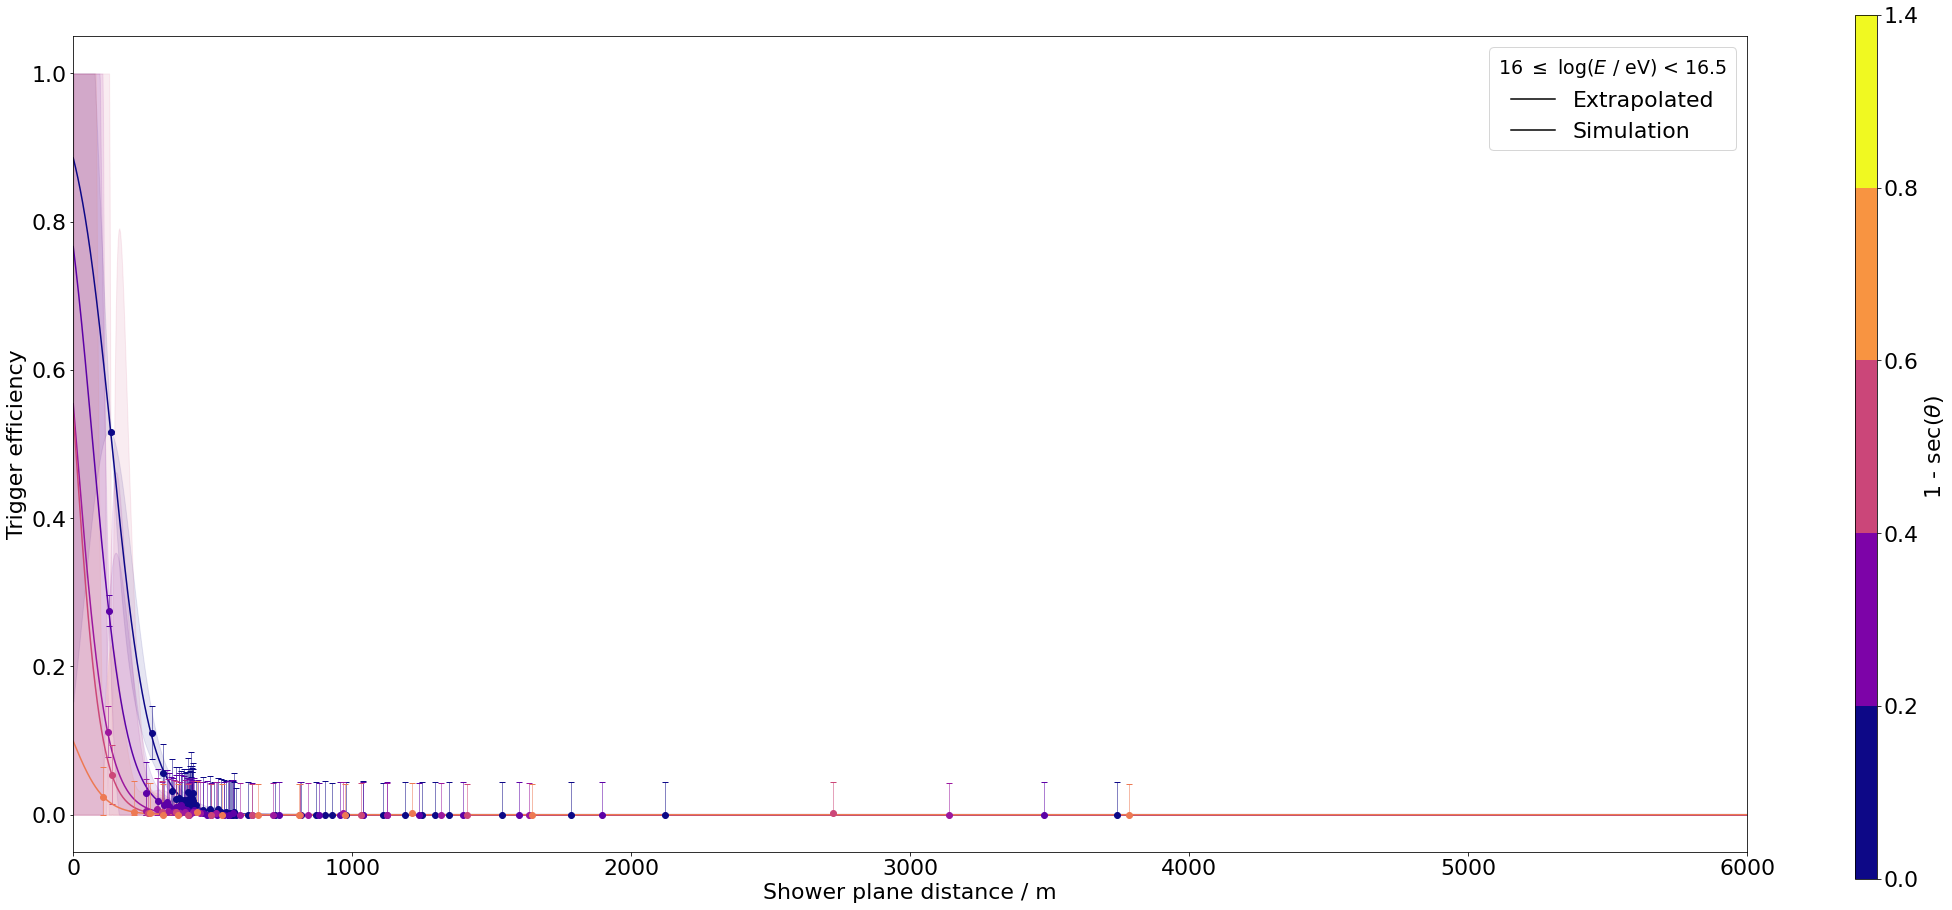

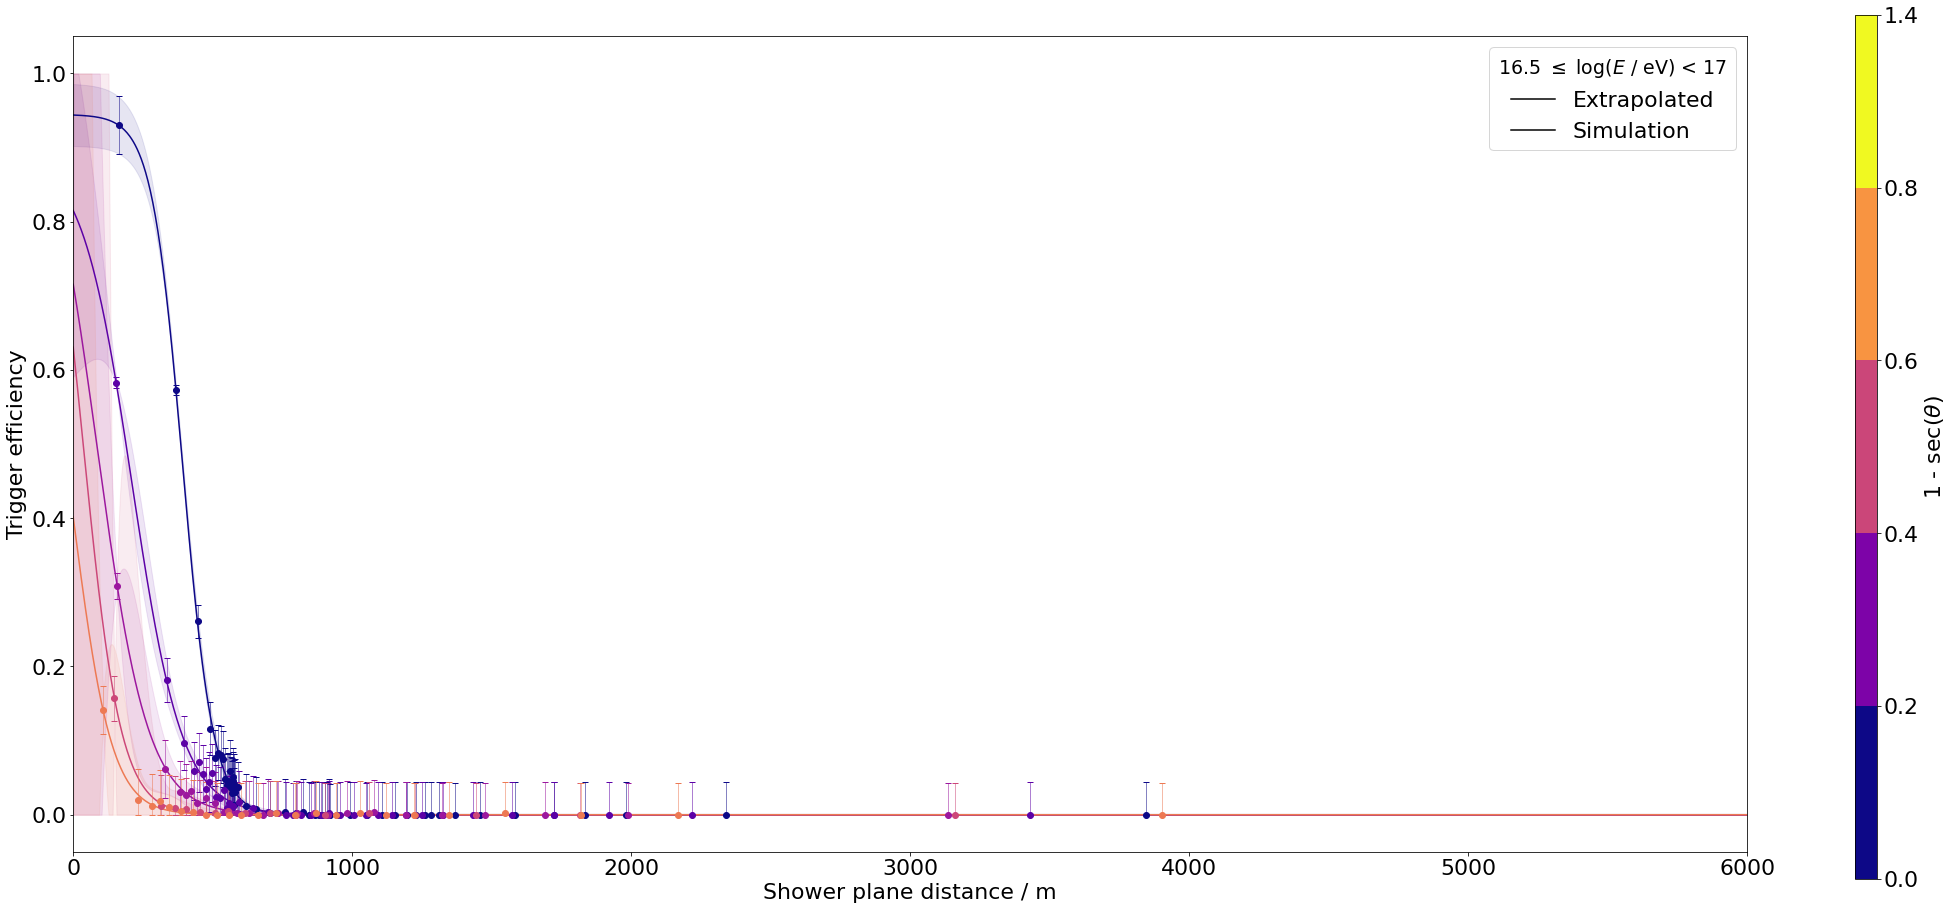

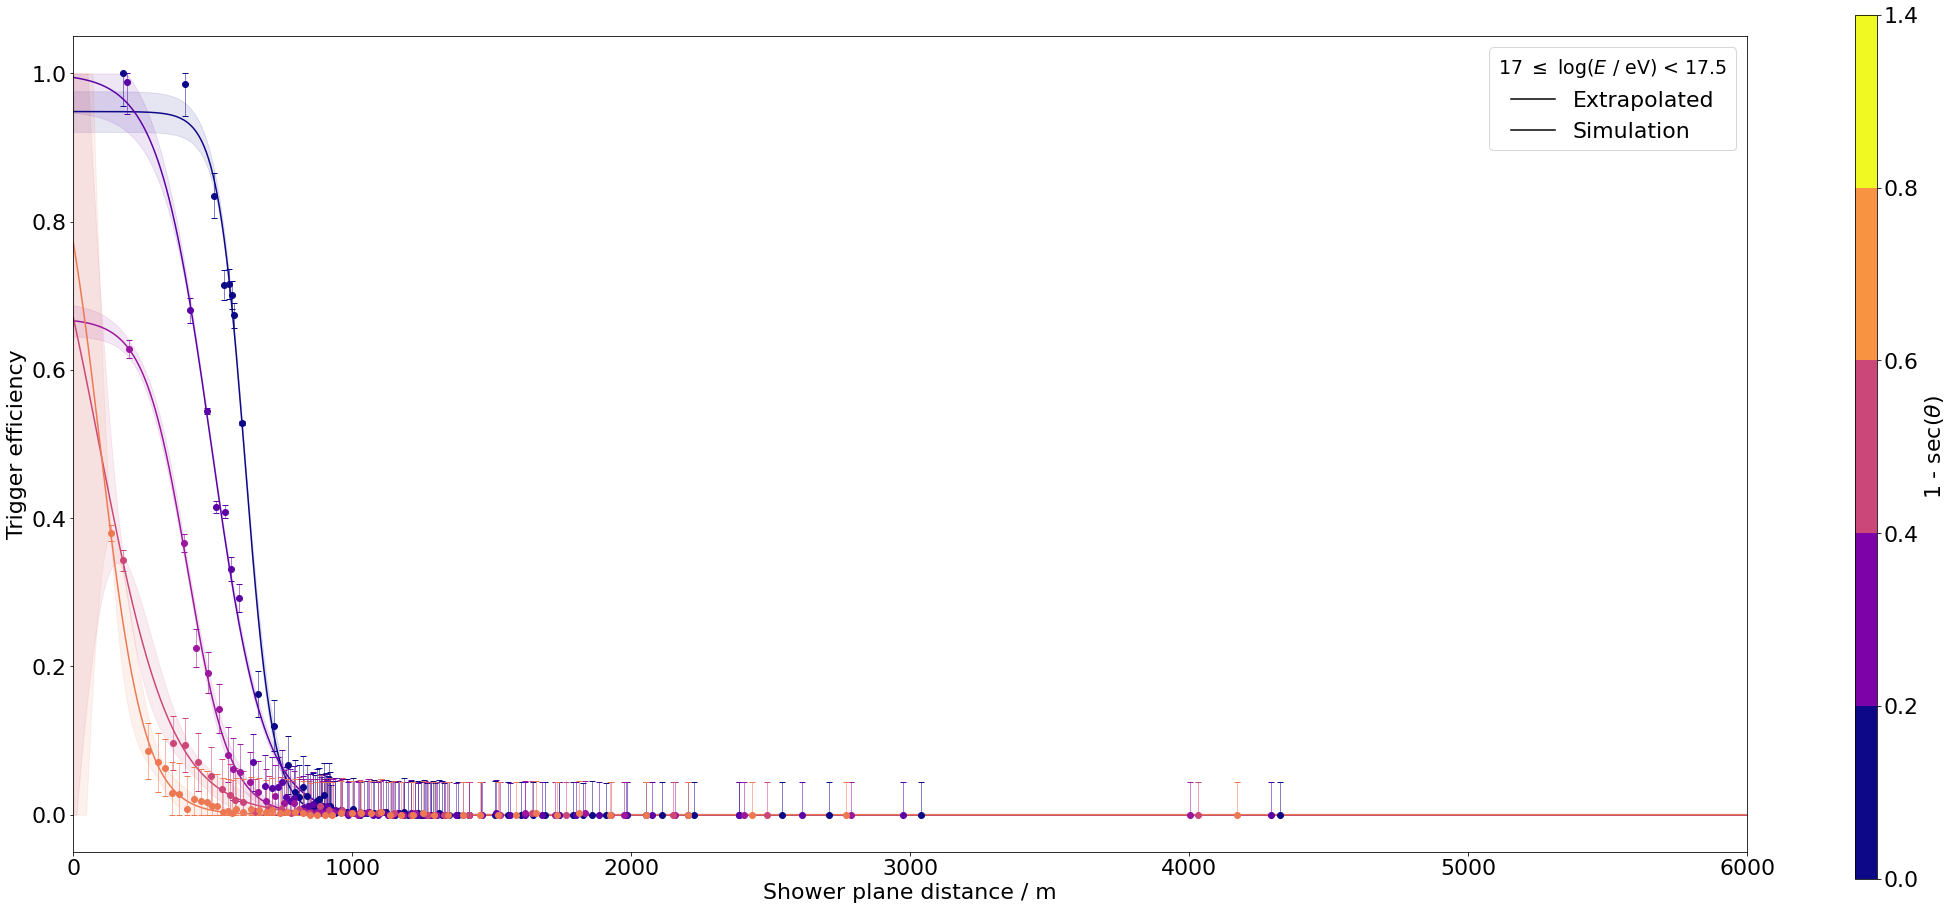

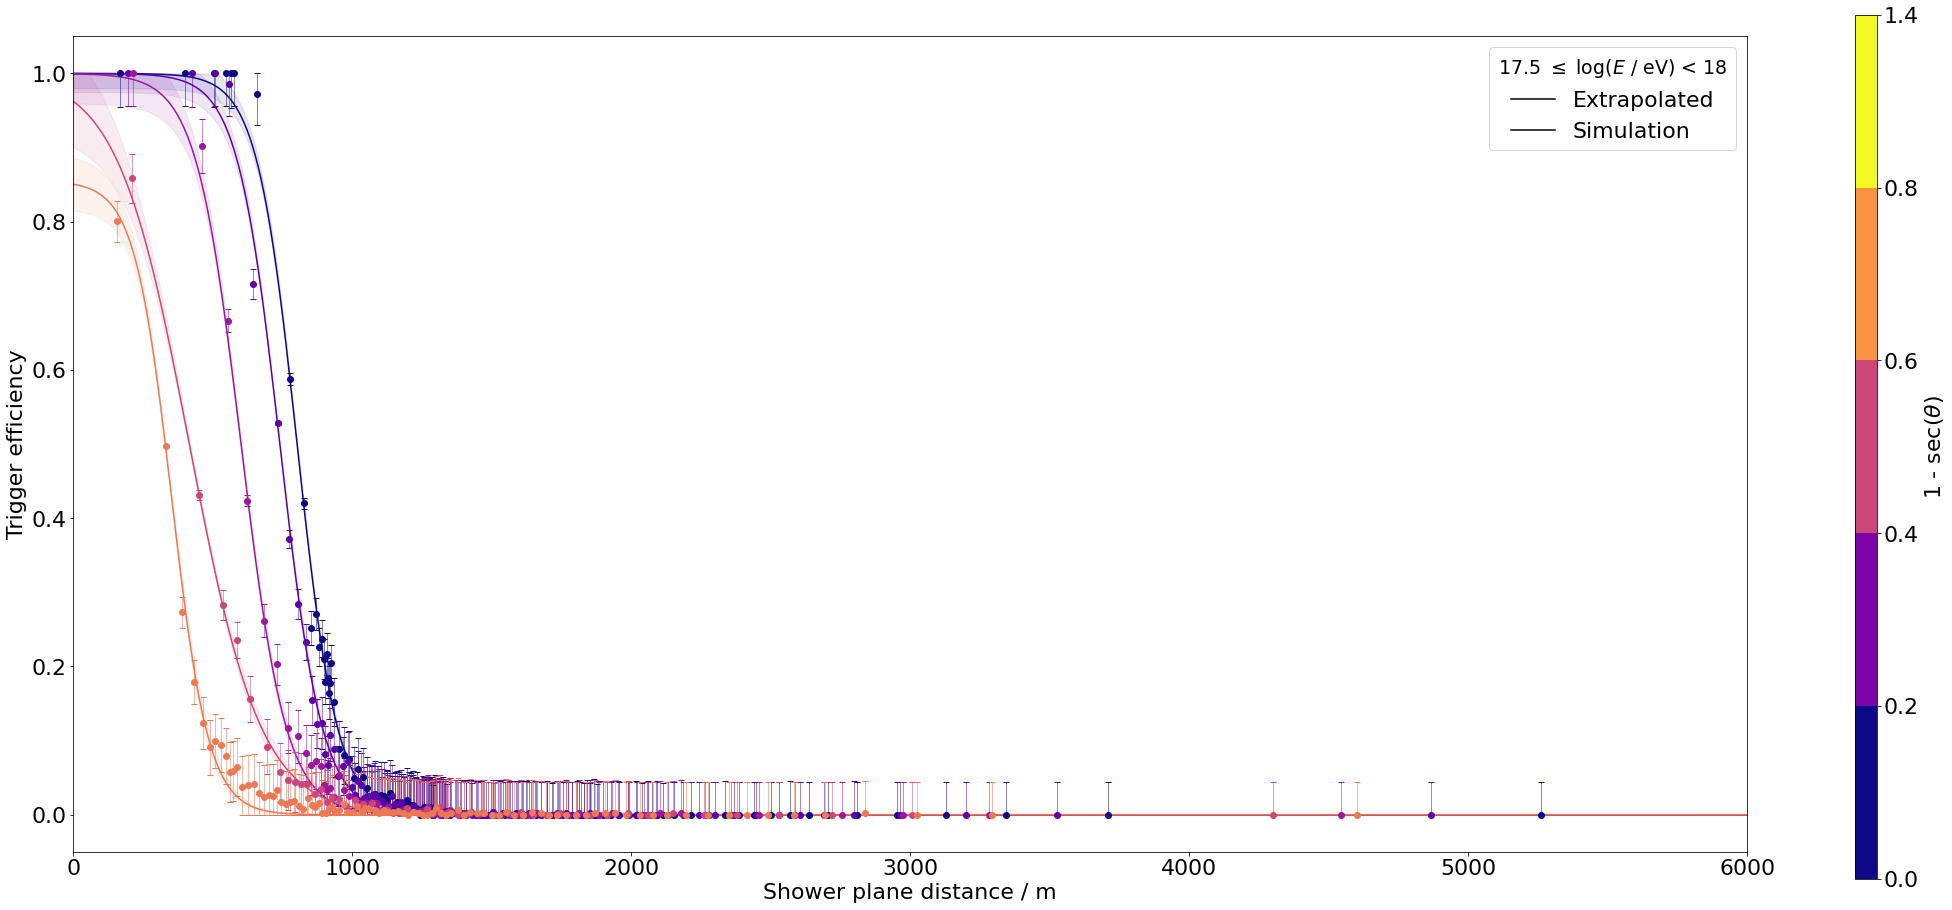

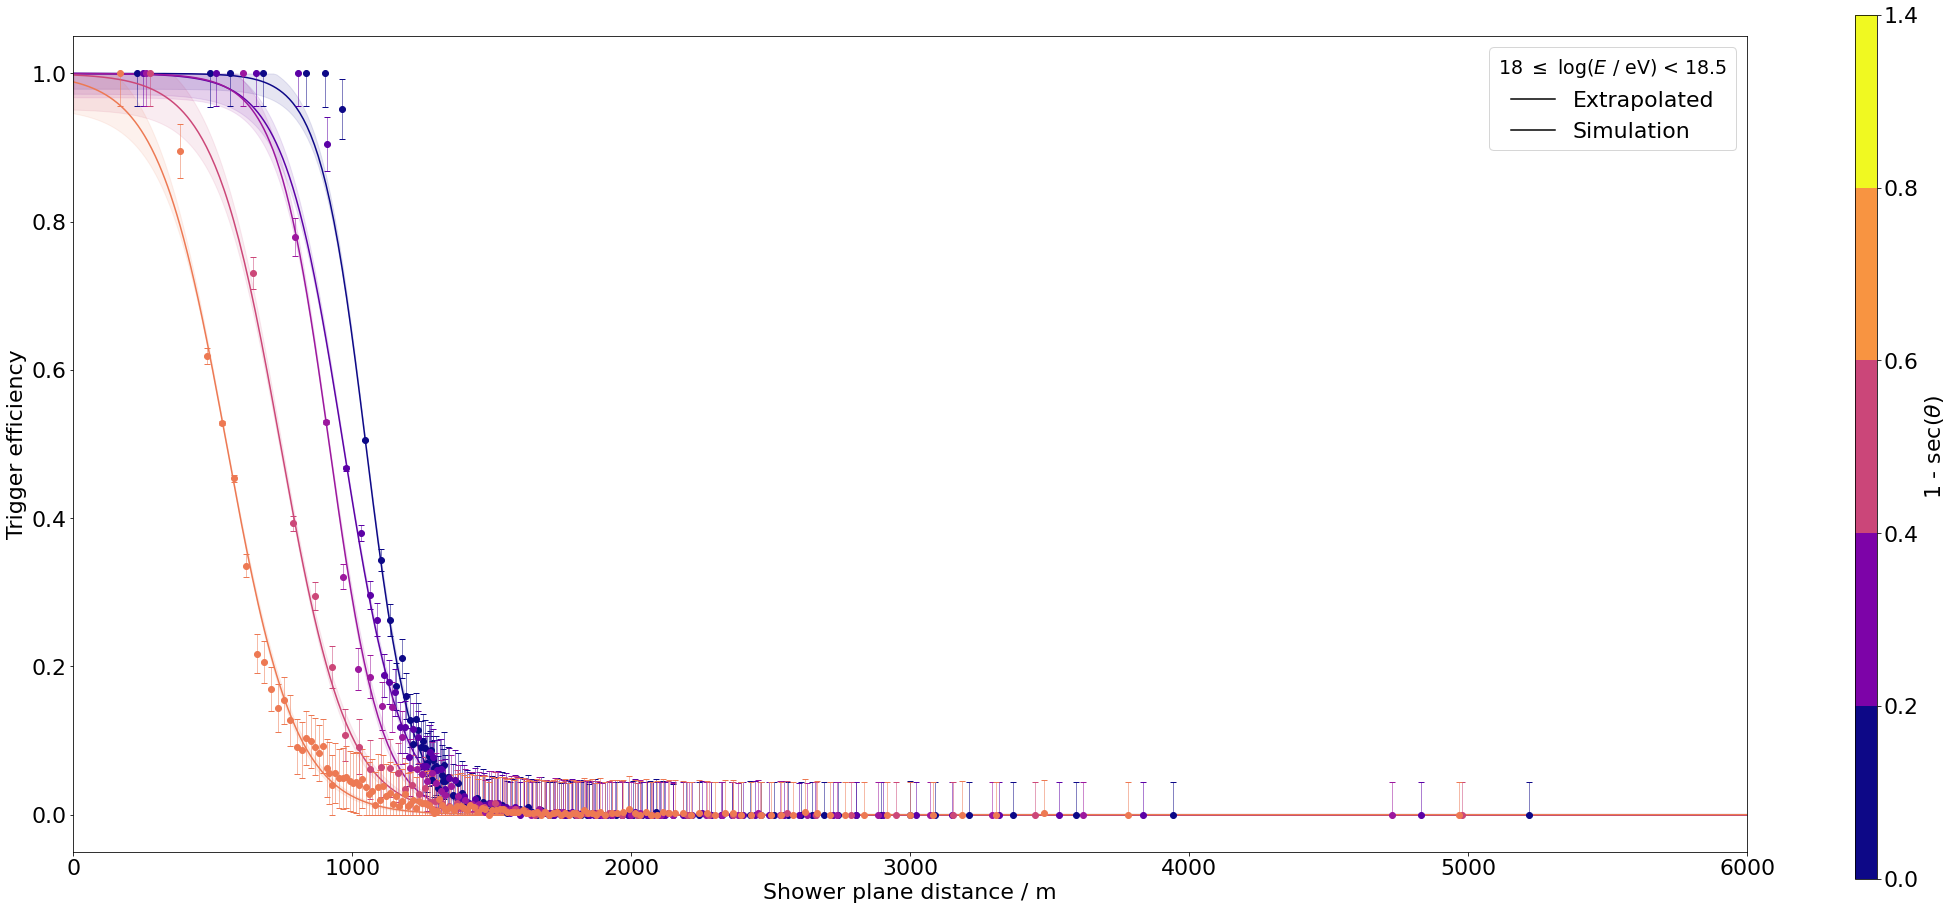

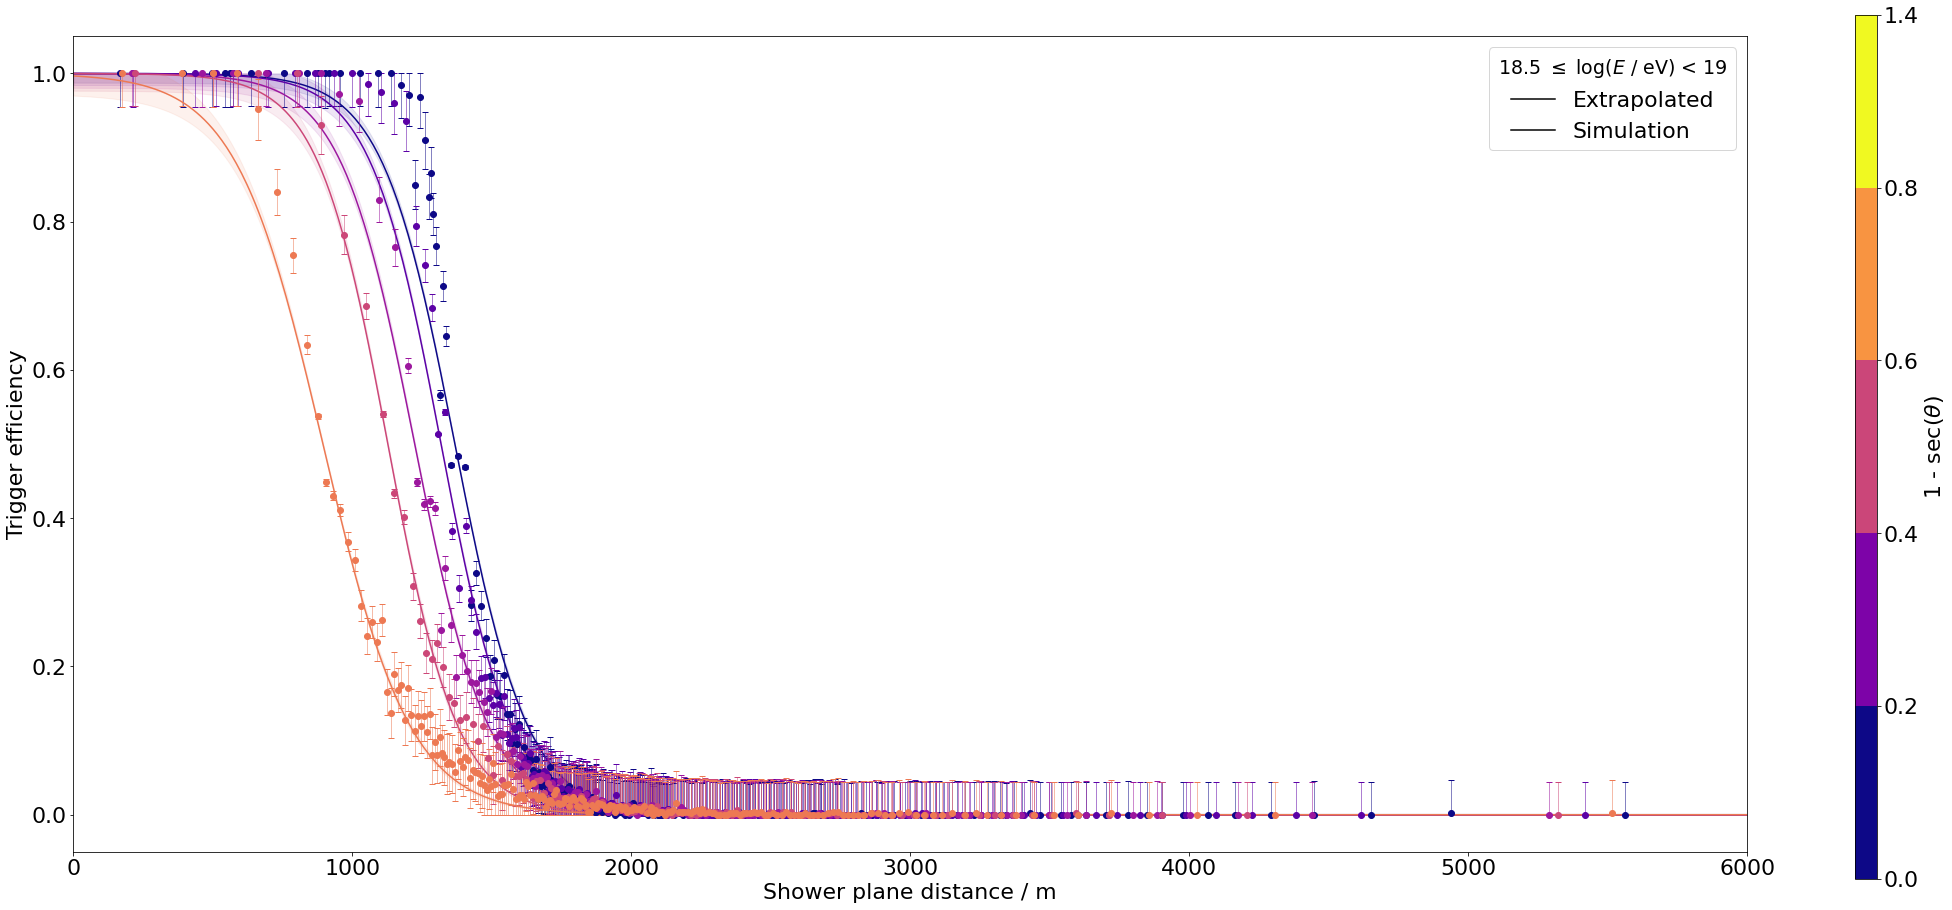

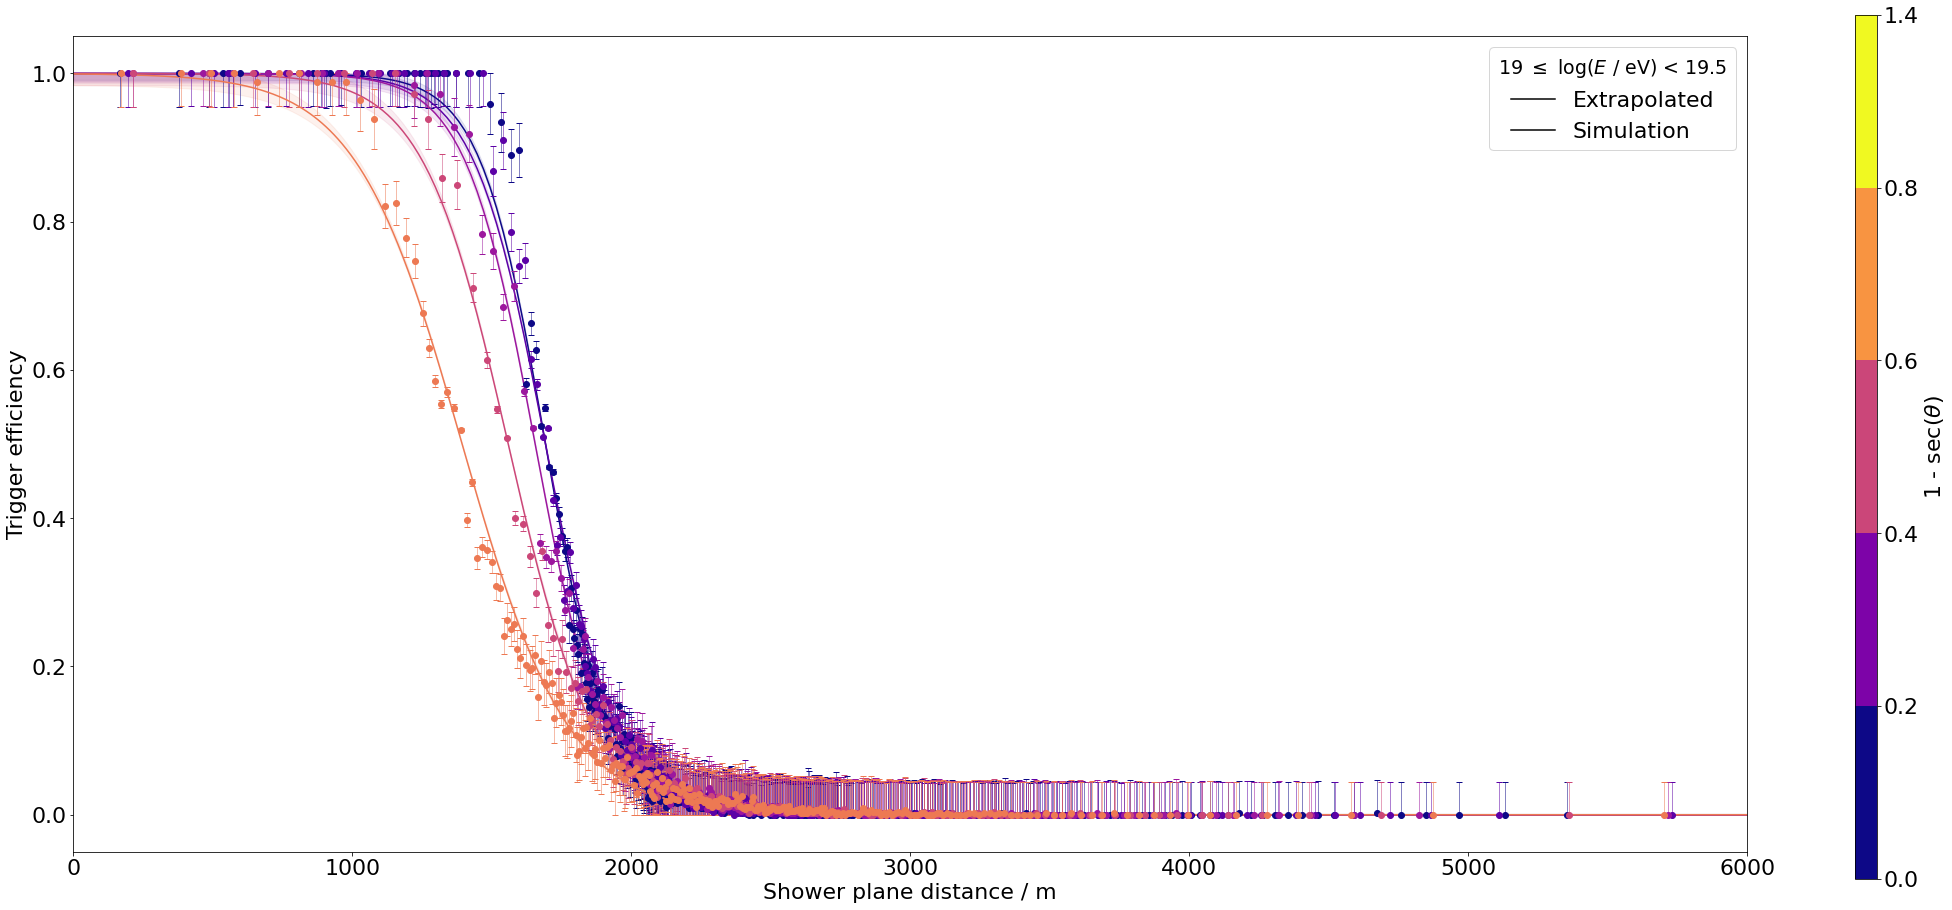

In [1]:
from Binaries import *

Hardware = HardwareClassifier()

Hardware.spd_energy_efficiency("fullscale_random_traces_downsampled_scaled")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 40, 4)          40        
                                                                 
 conv1d (Conv1D)             (None, 1, 20, 2)          18        
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________

120_TwoLayer_HighEnergy_NoCuts                all_energies                         340283       0       0  123493 -> ACC =  73.37%


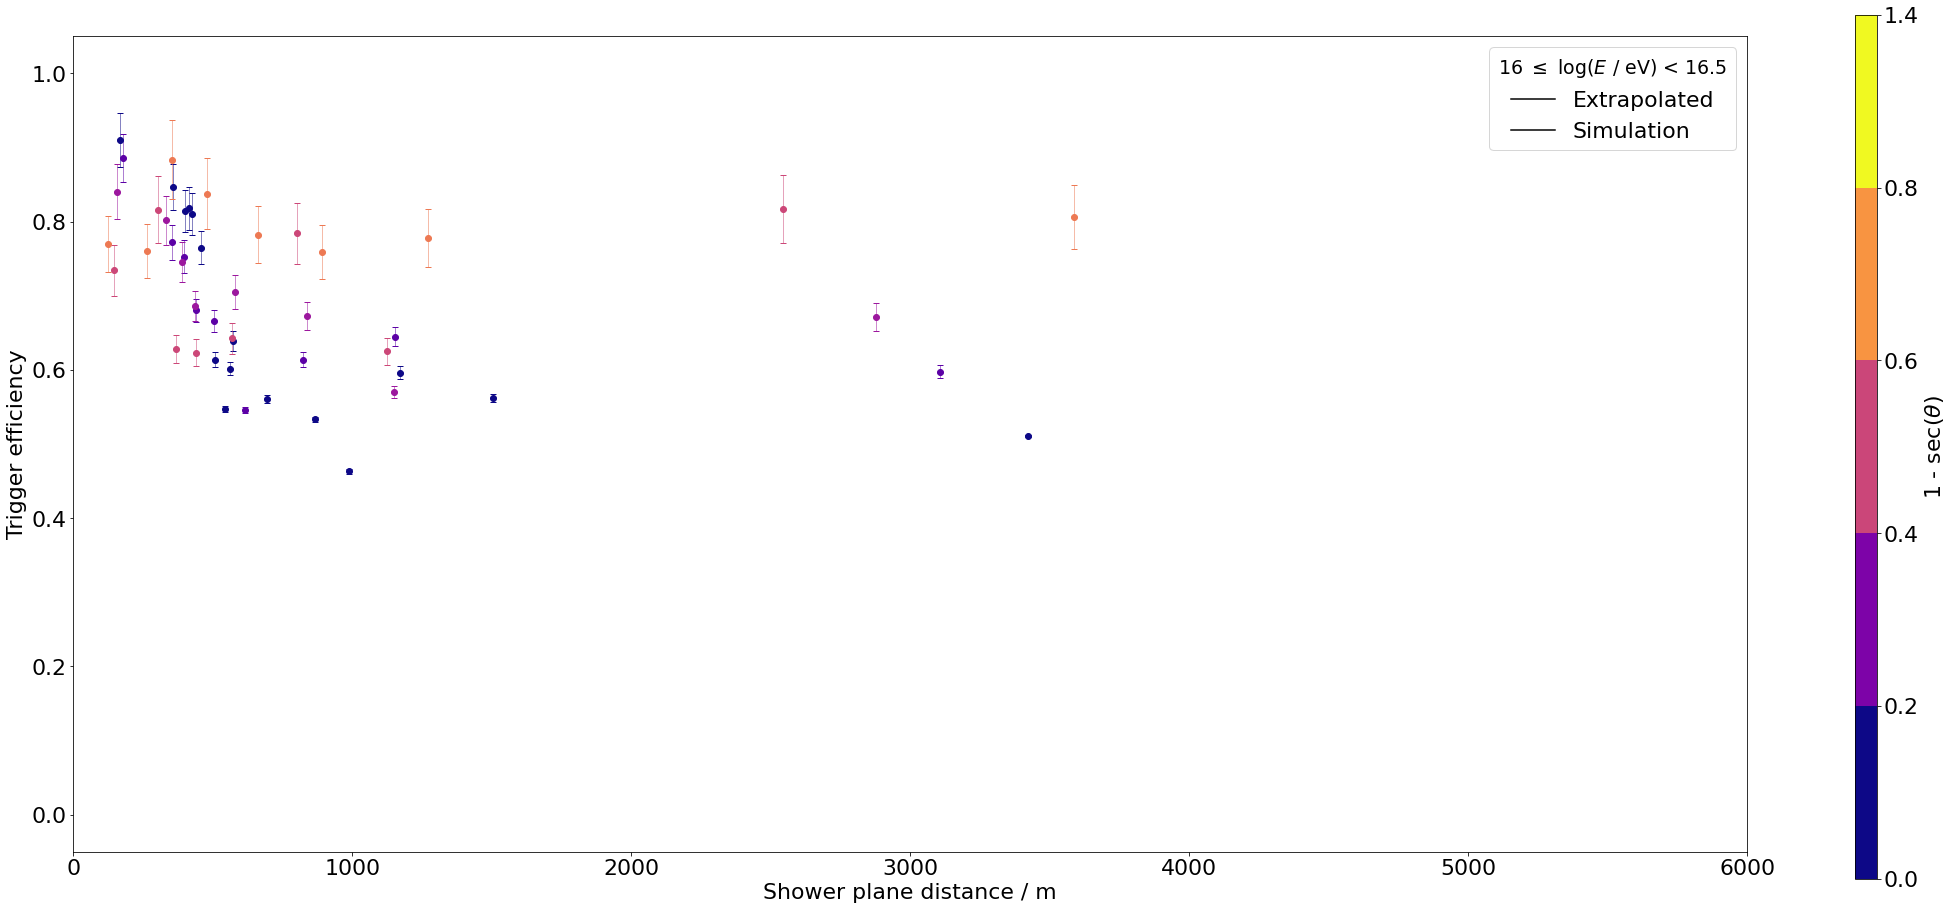

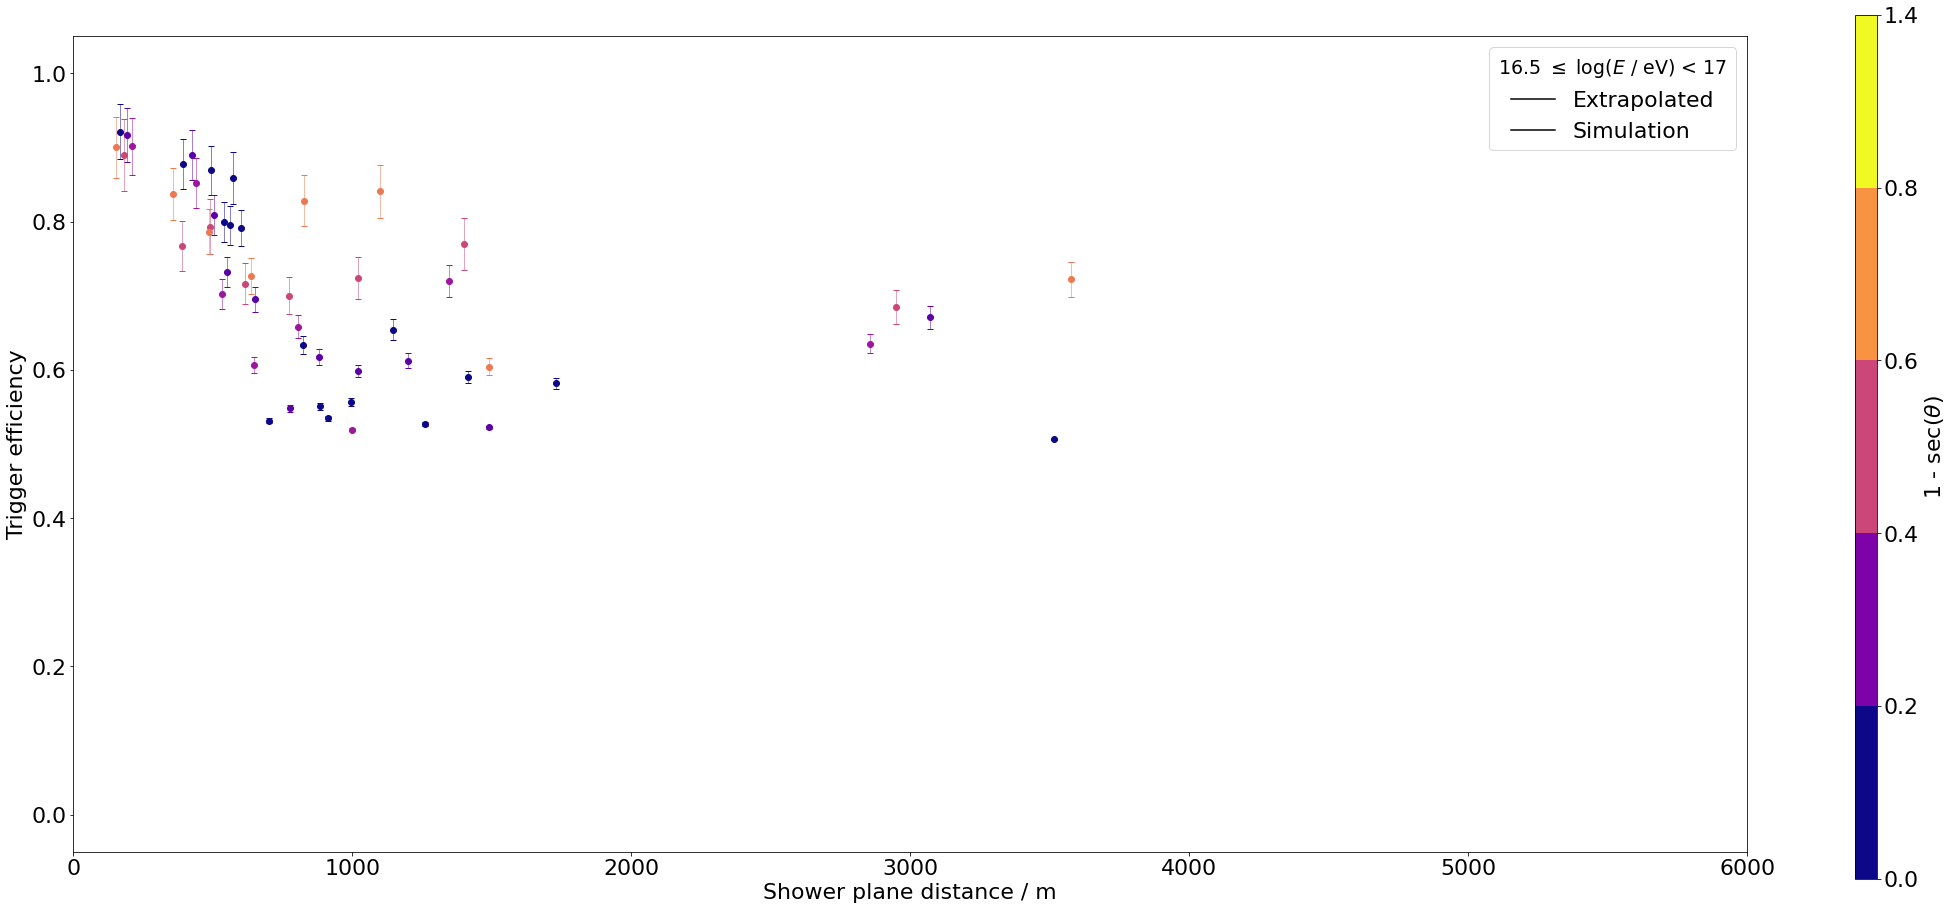

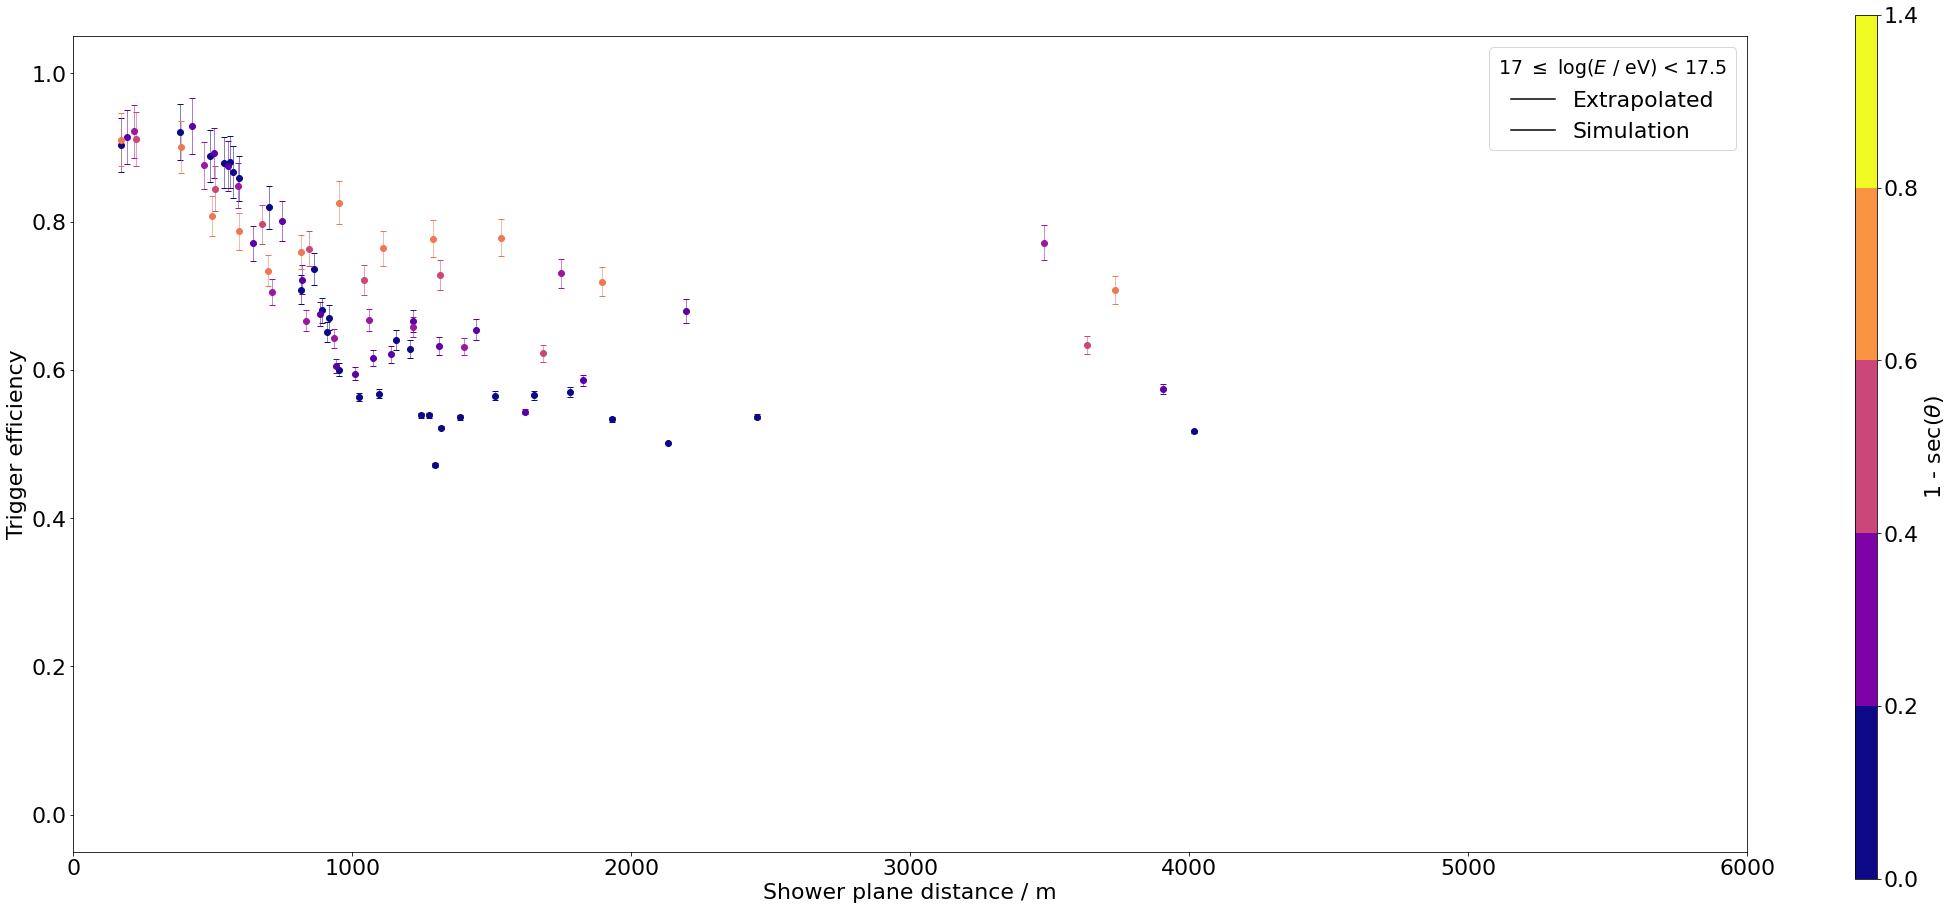

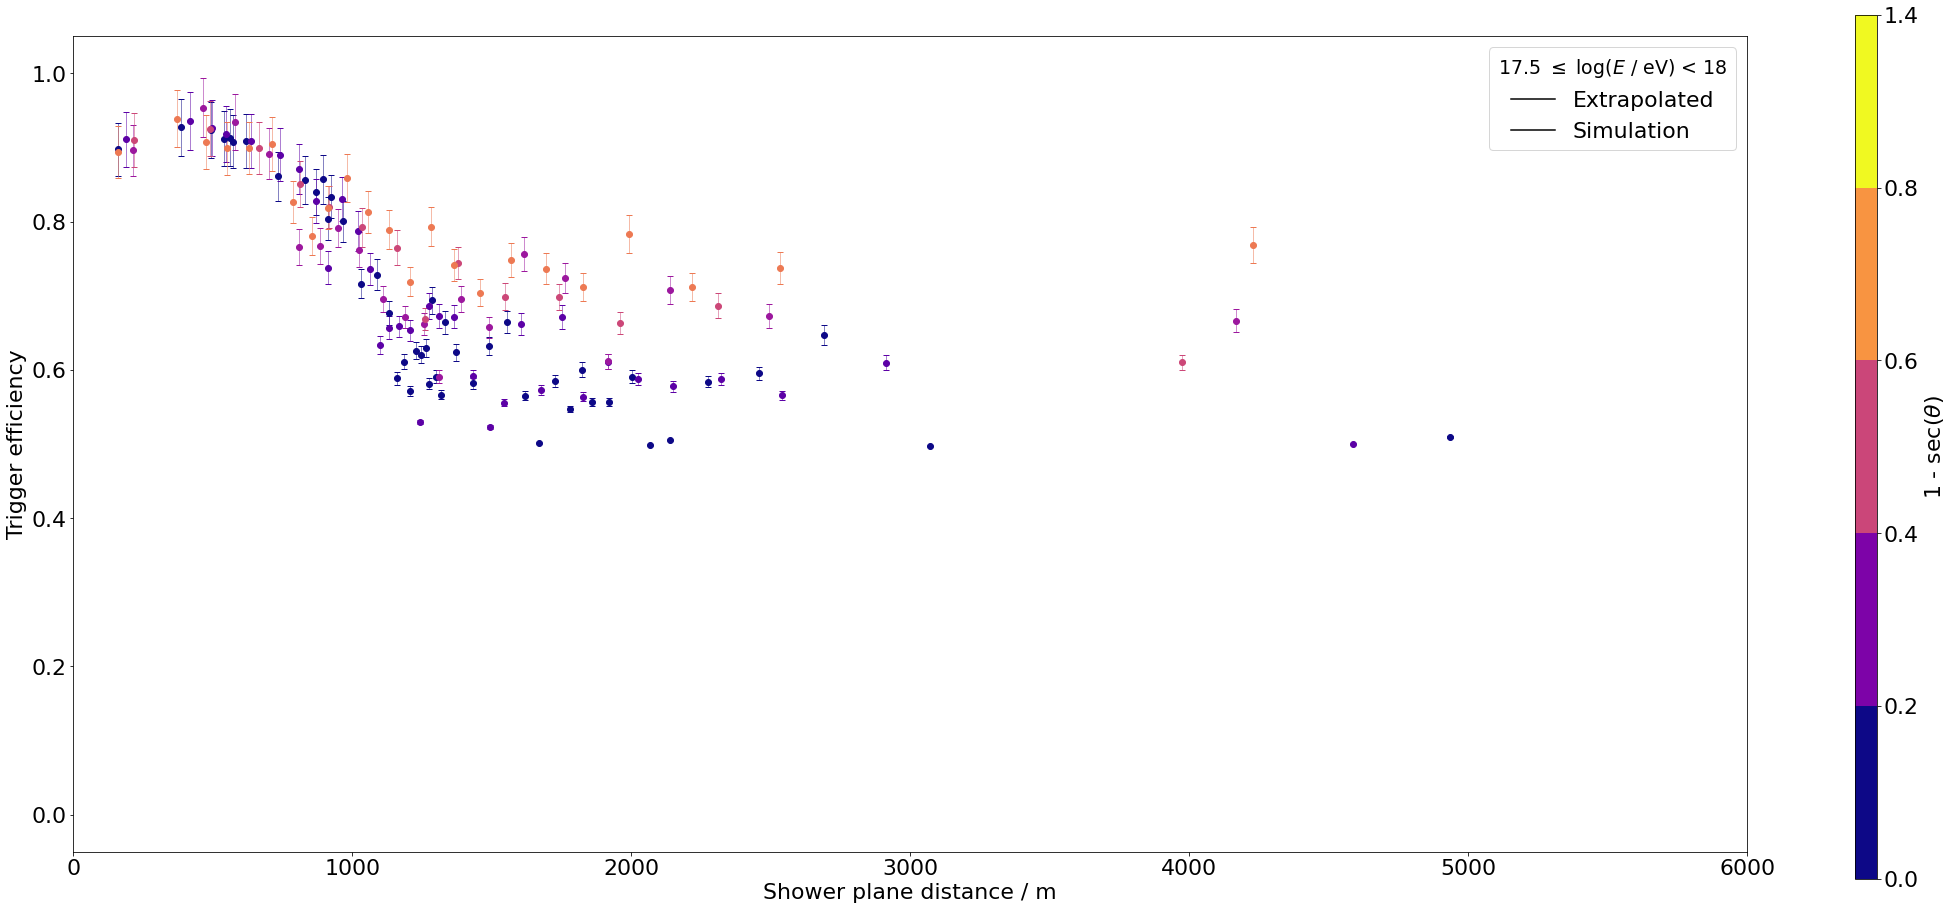

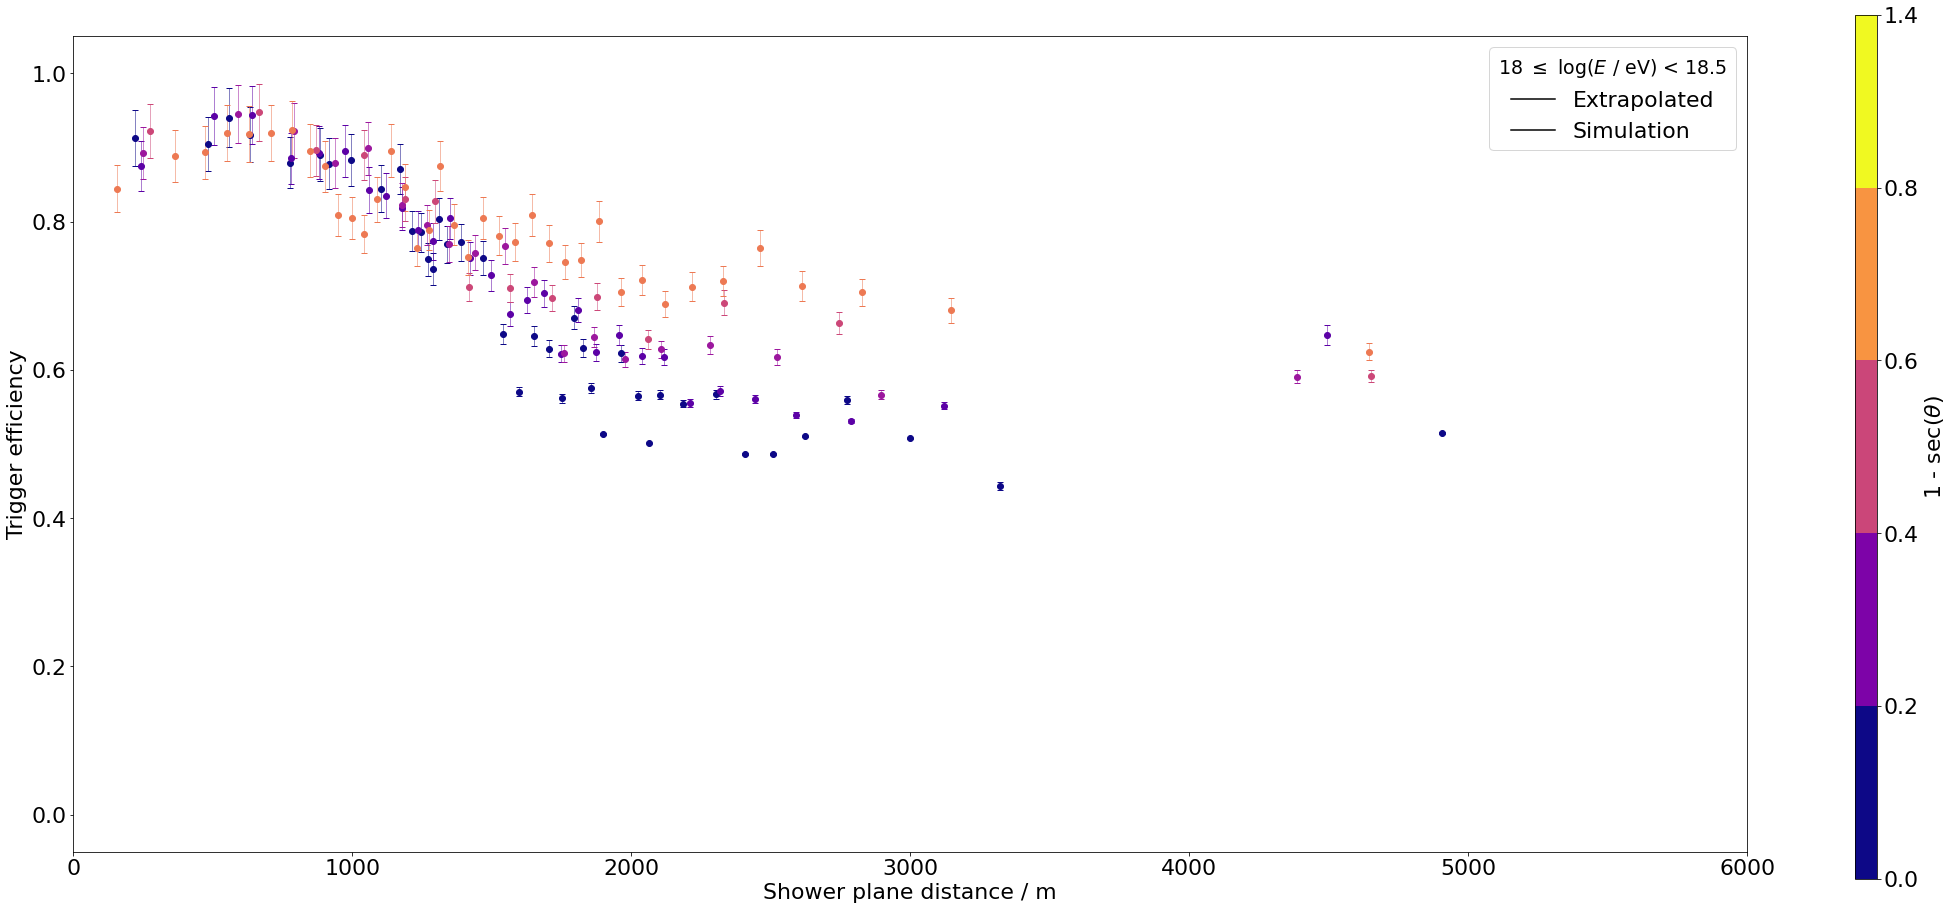

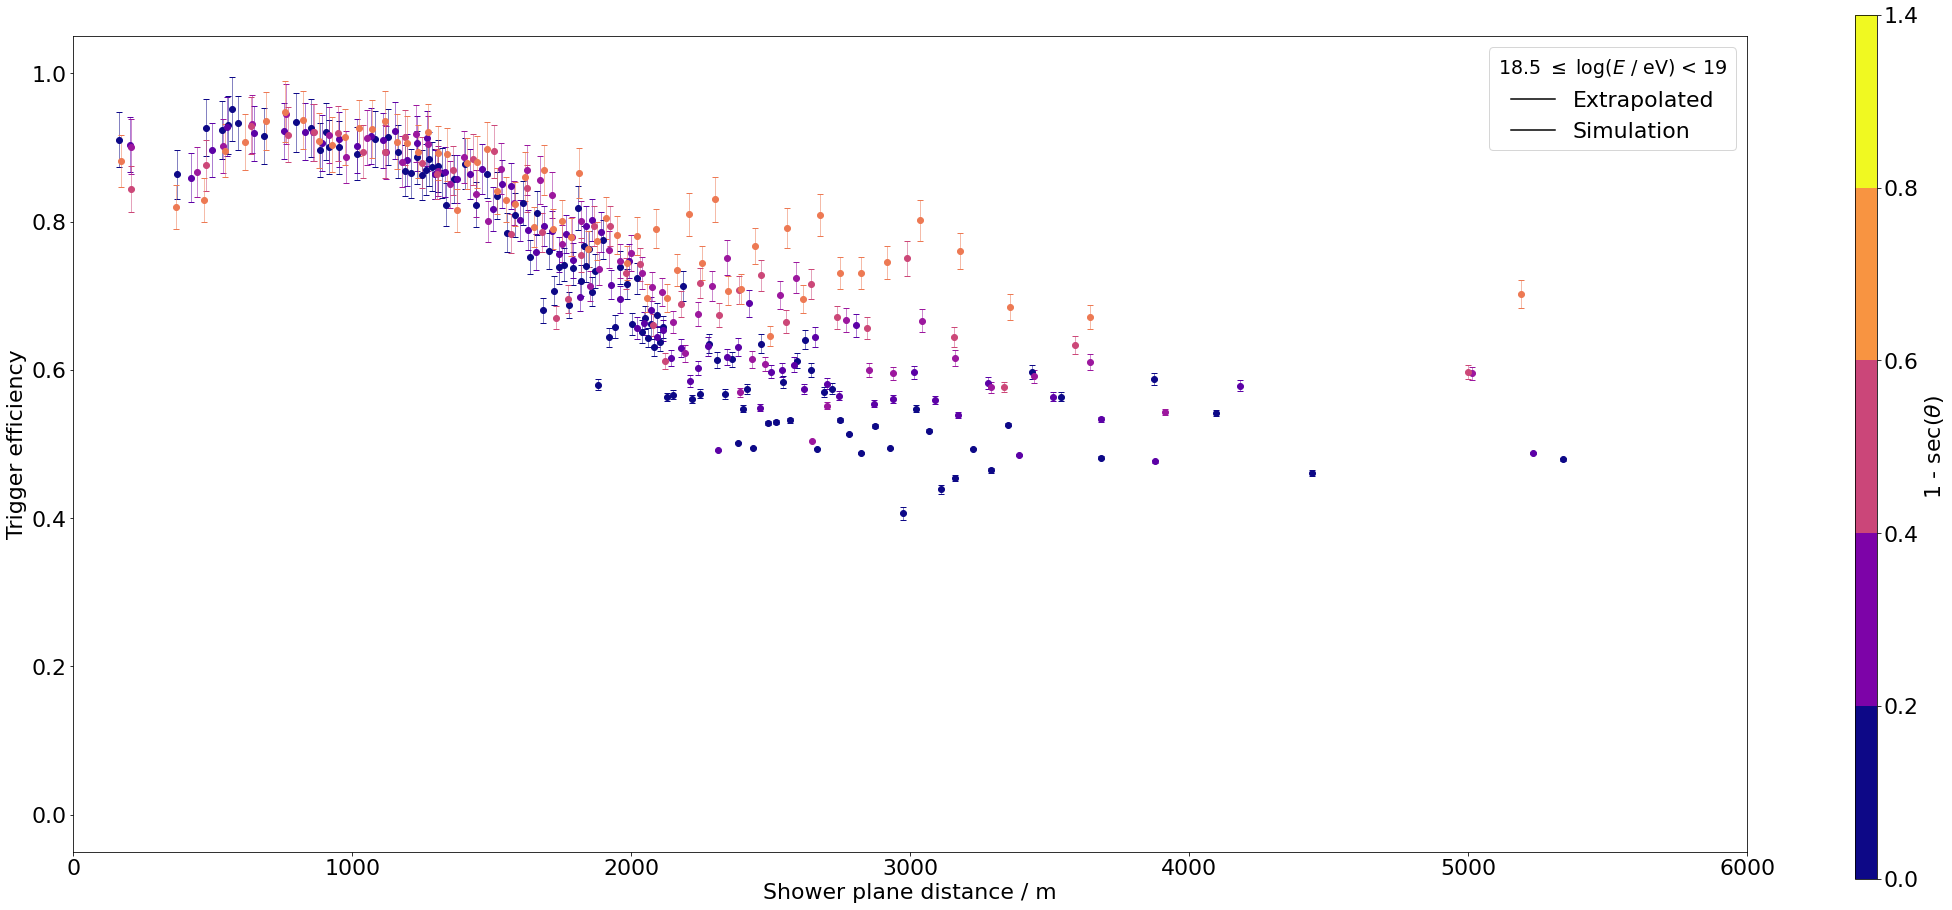

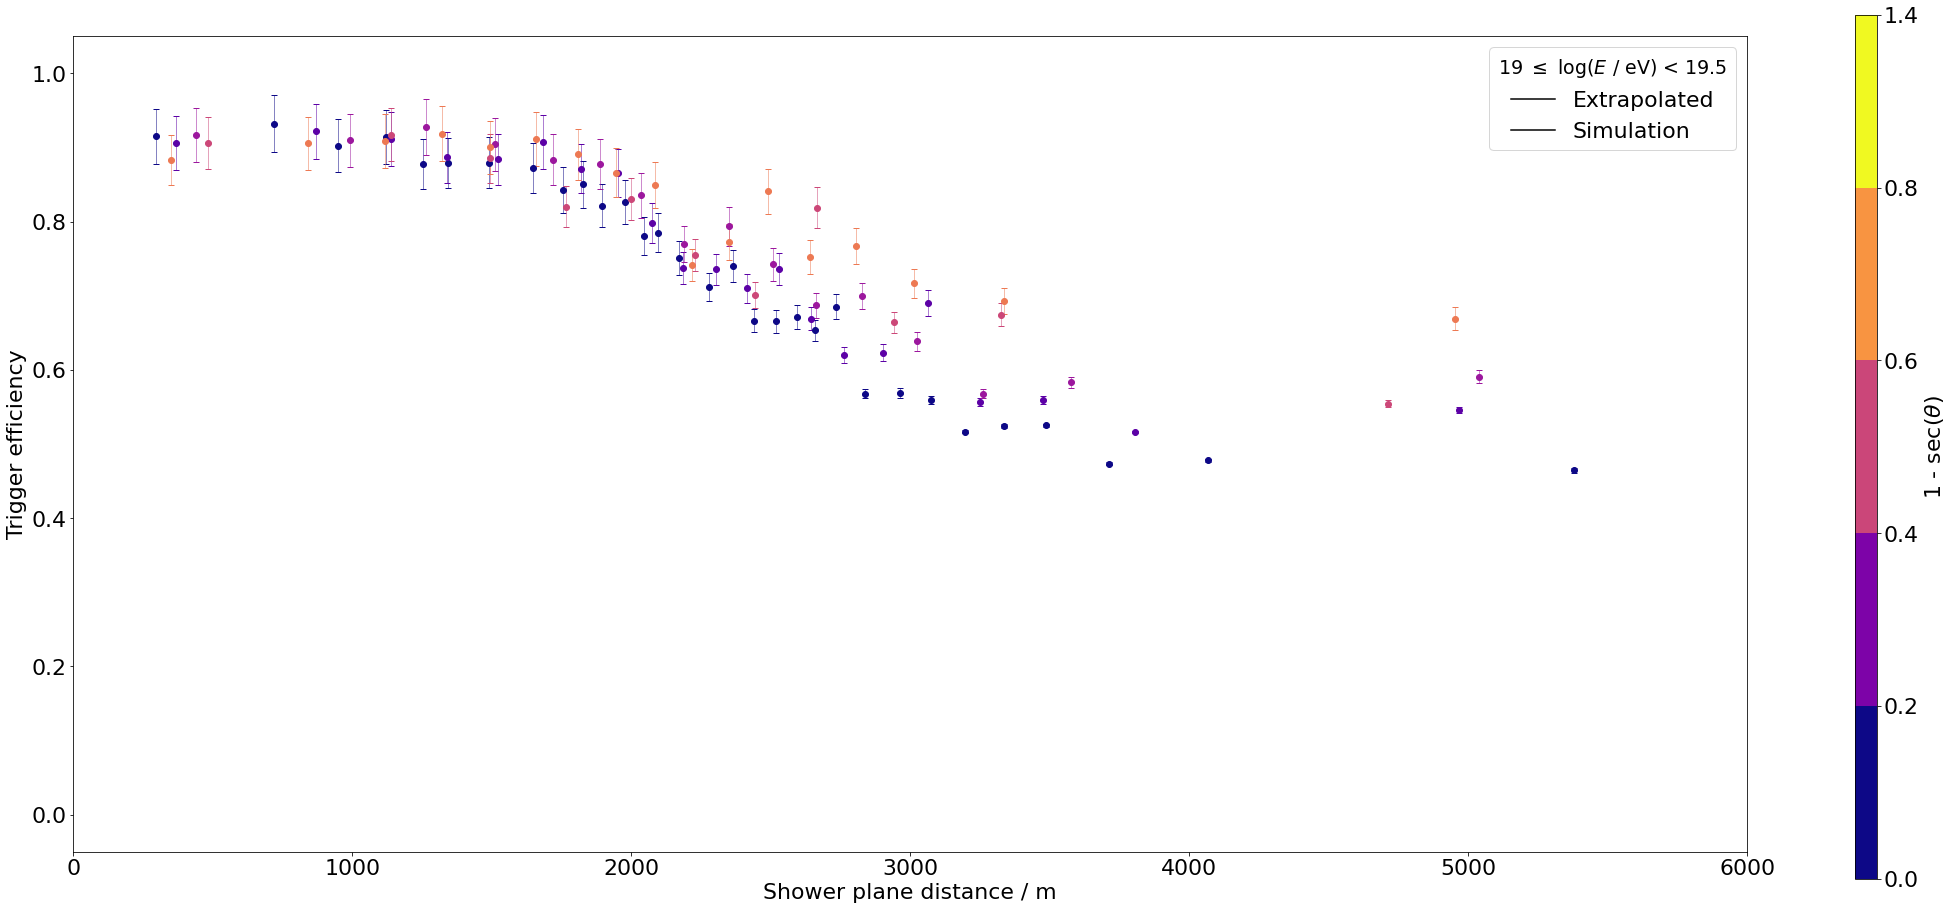

In [4]:
Assifier = NNClassifier("120_TwoLayer_HighEnergy_NoCuts")
Assifier.spd_energy_efficiency("all_energies", perform_fit = False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 40, 4)          40        
                                                                 
 conv1d (Conv1D)             (None, 1, 20, 2)          18        
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________

120_TwoLayer_FullBandwidth_NoCuts             validation_data                       83858       0       0   17609 -> ACC =  82.65%


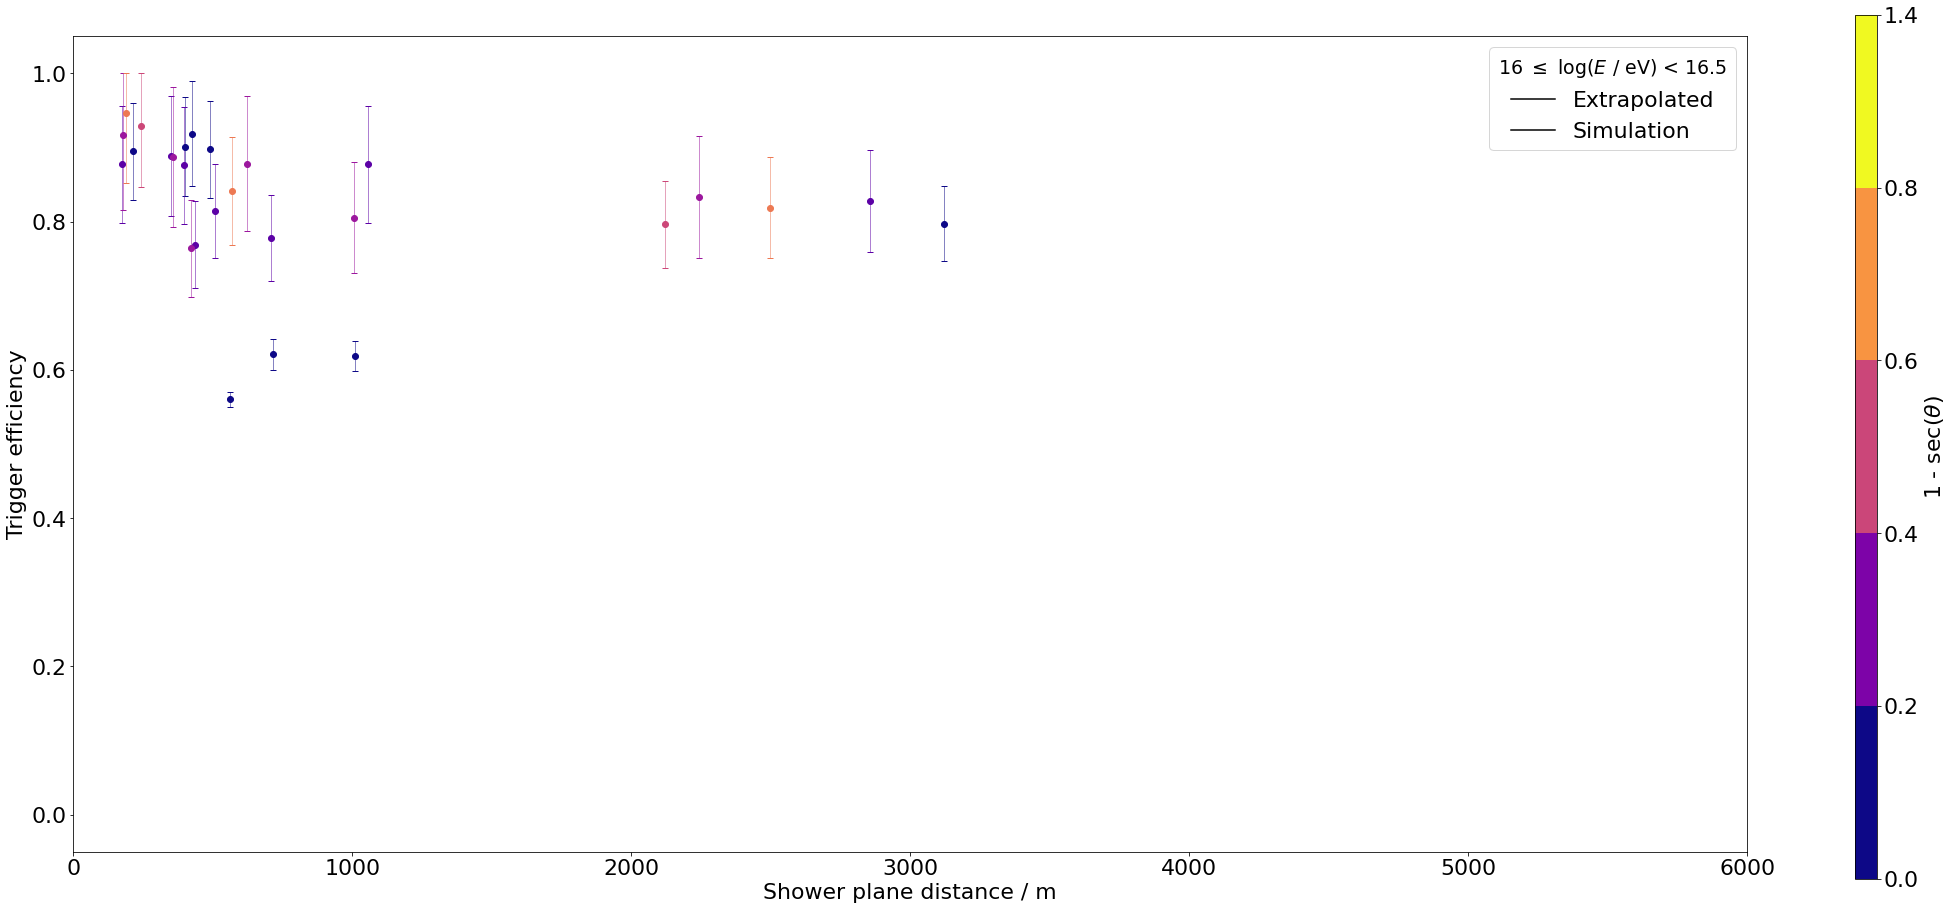

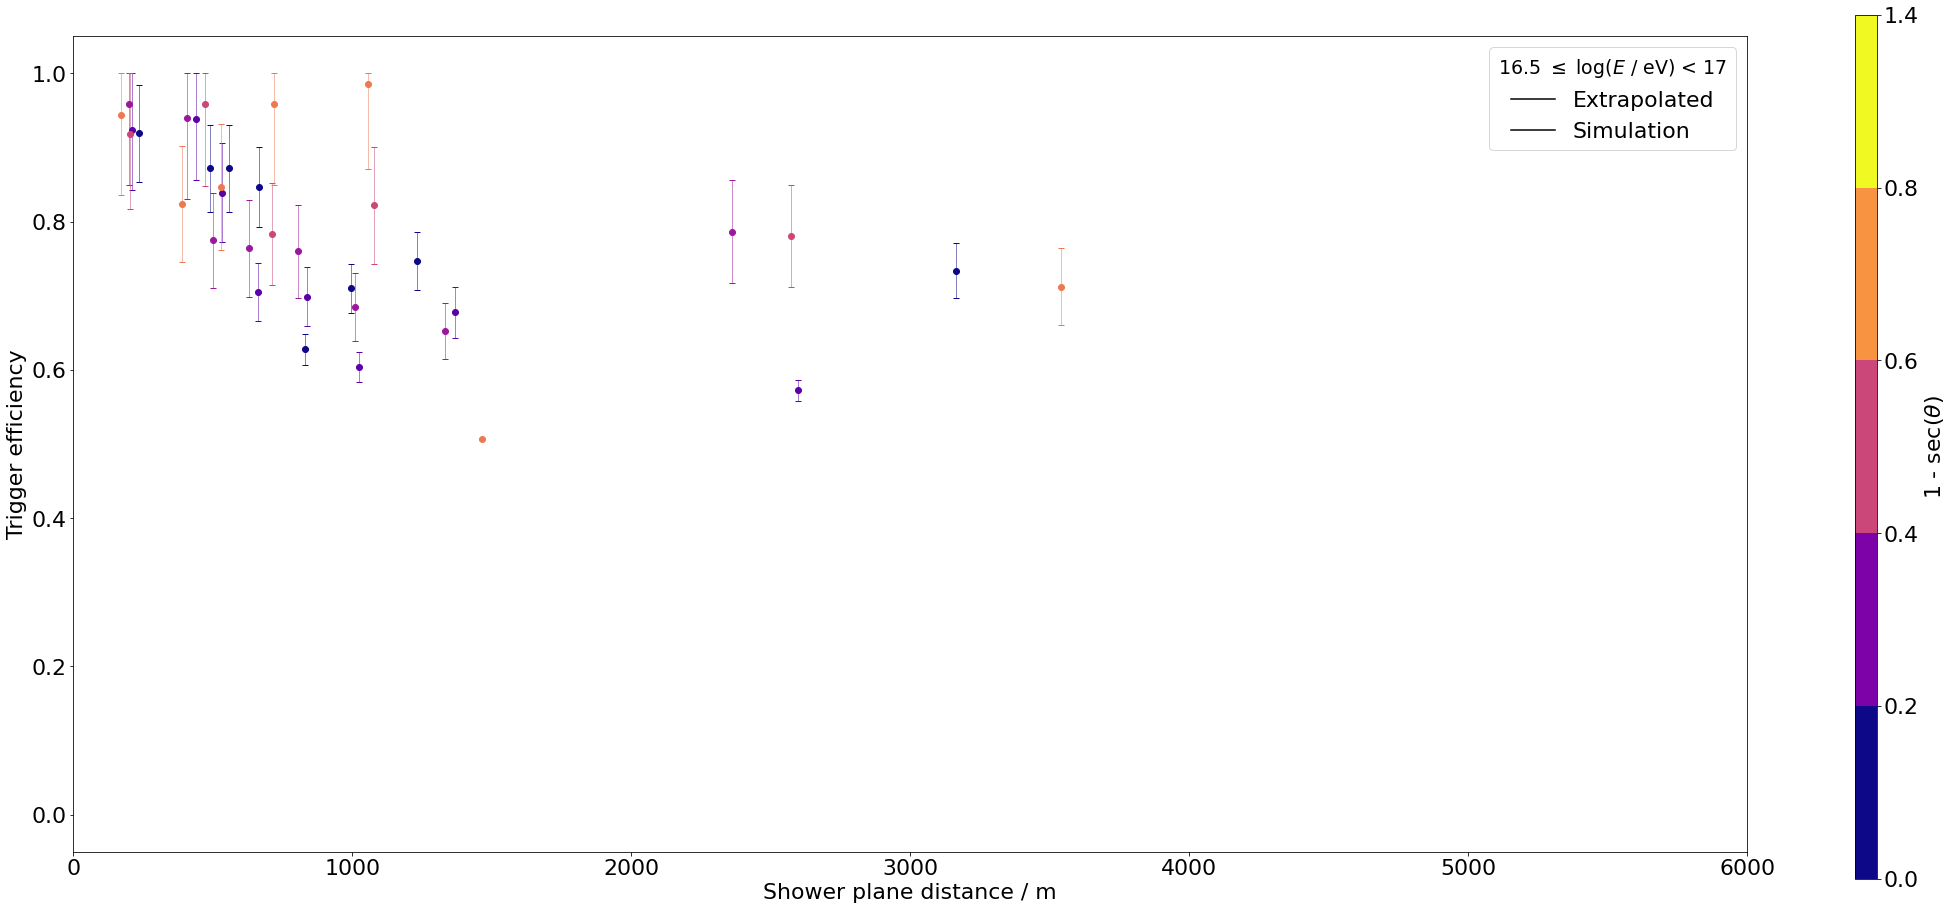

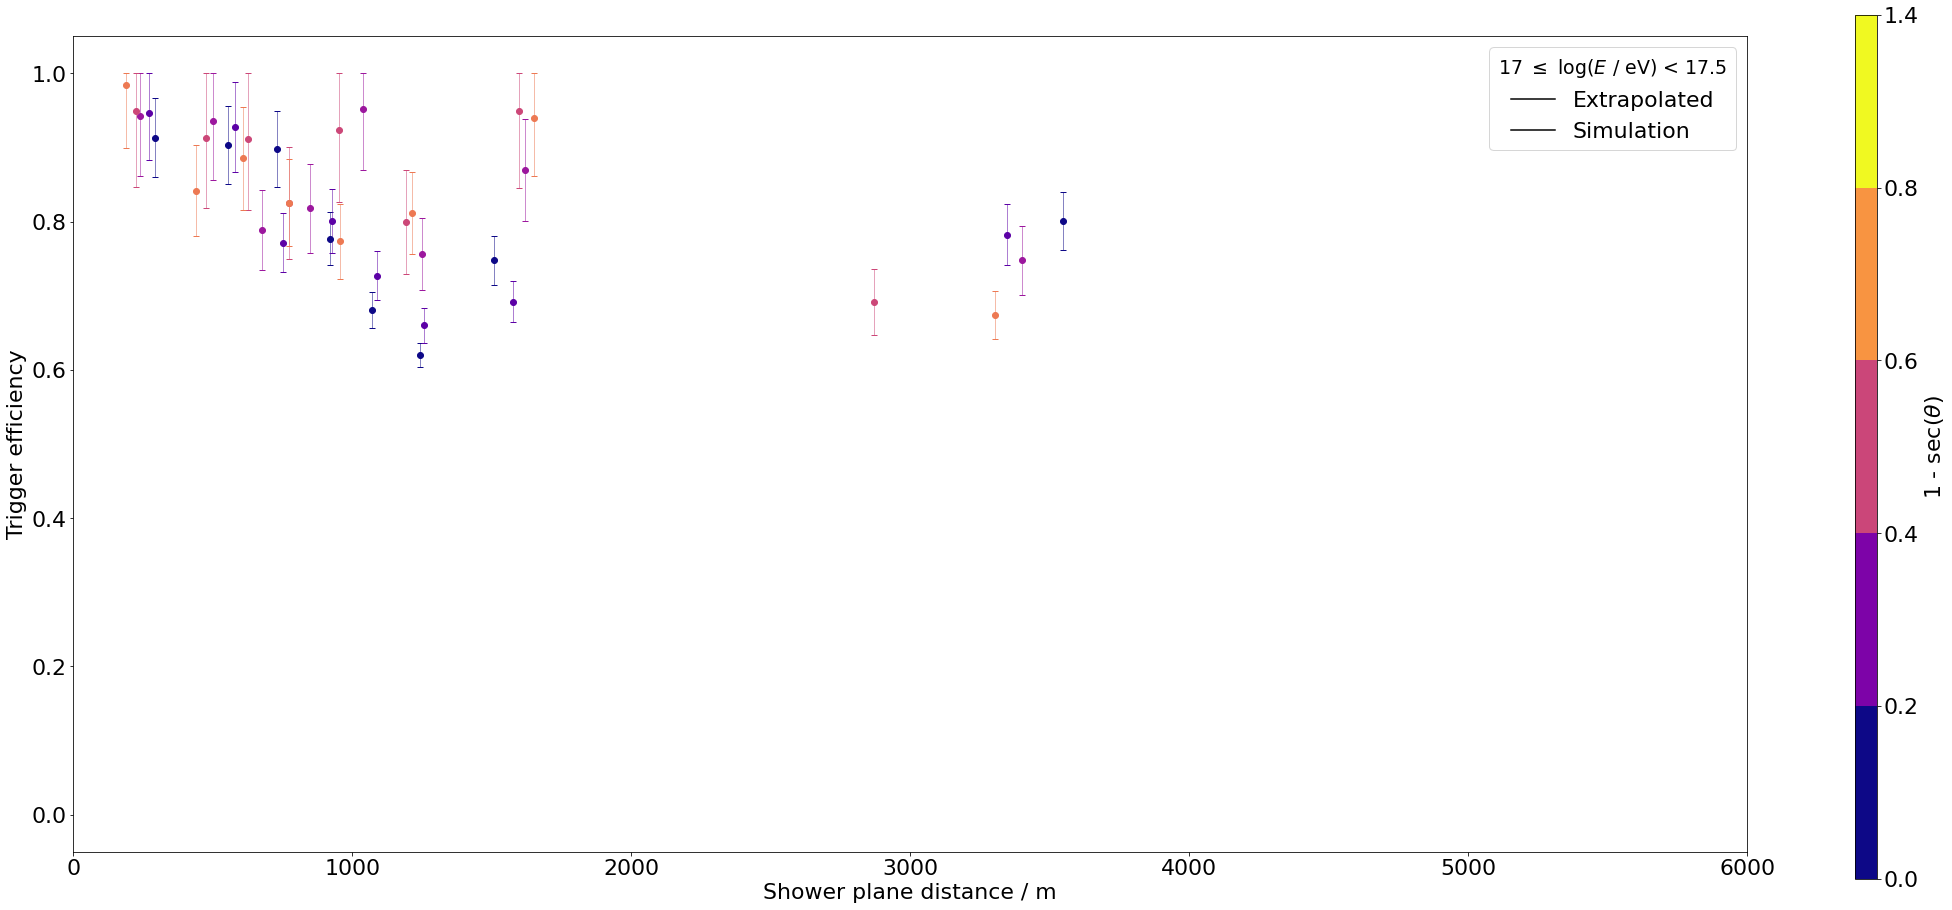

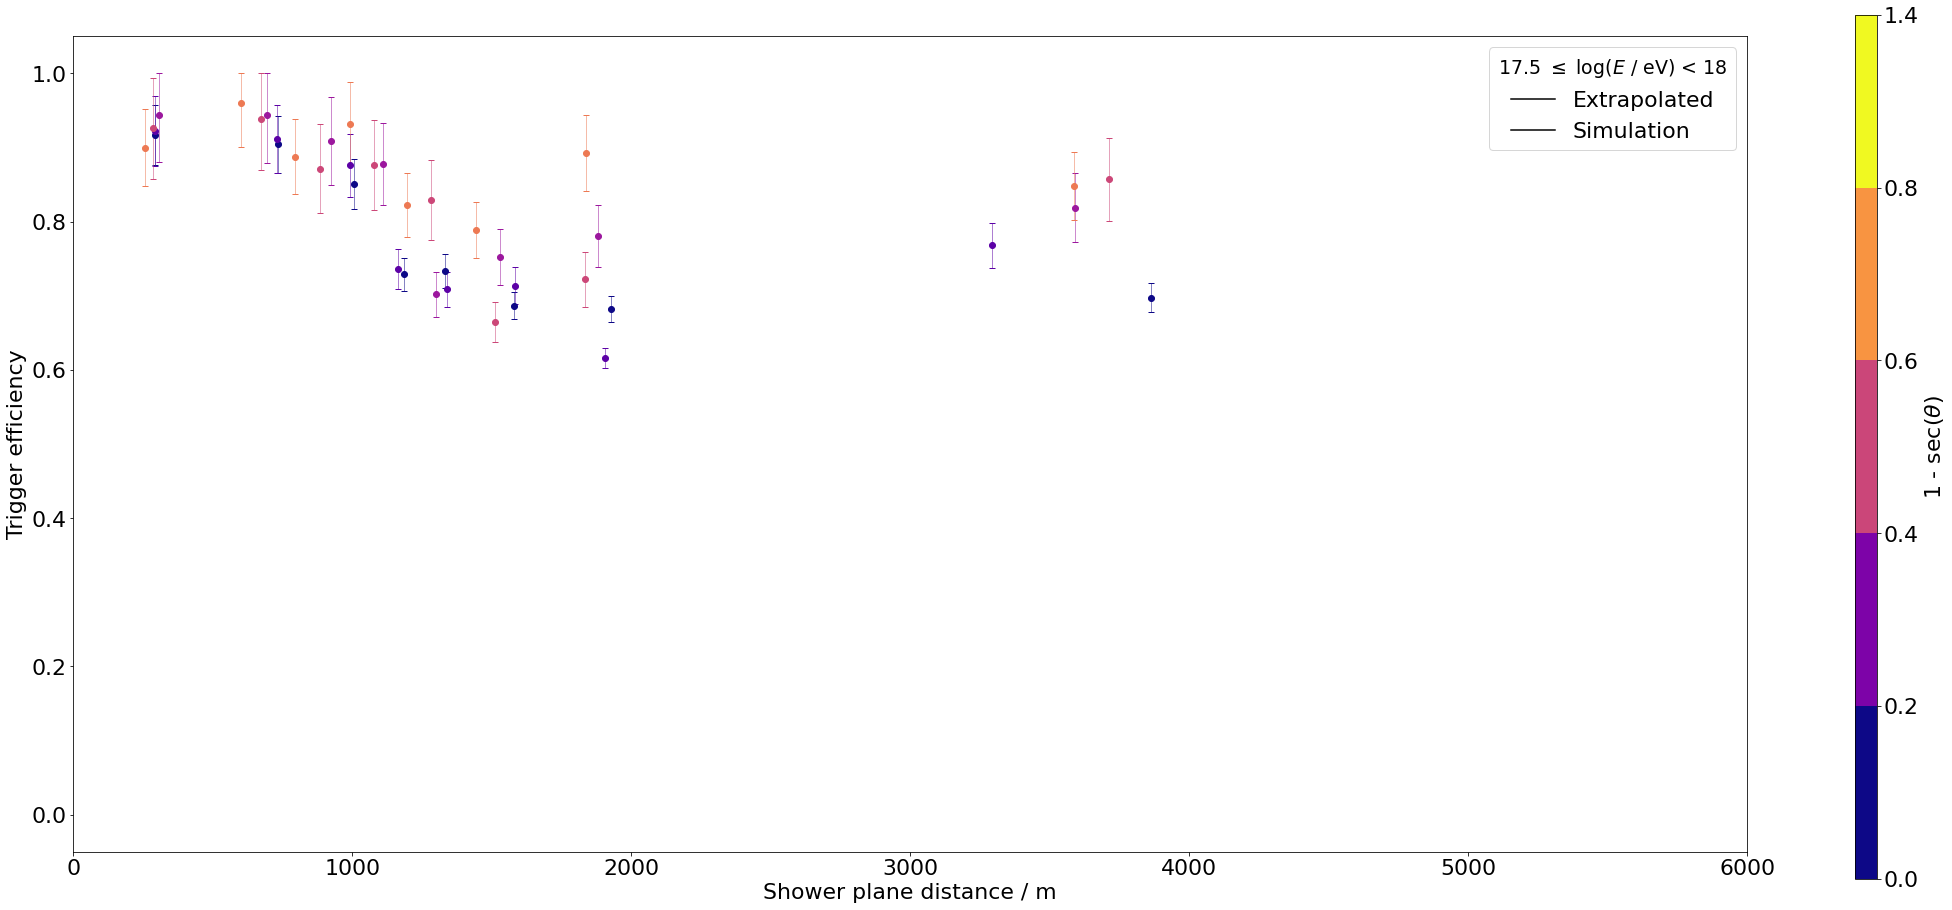

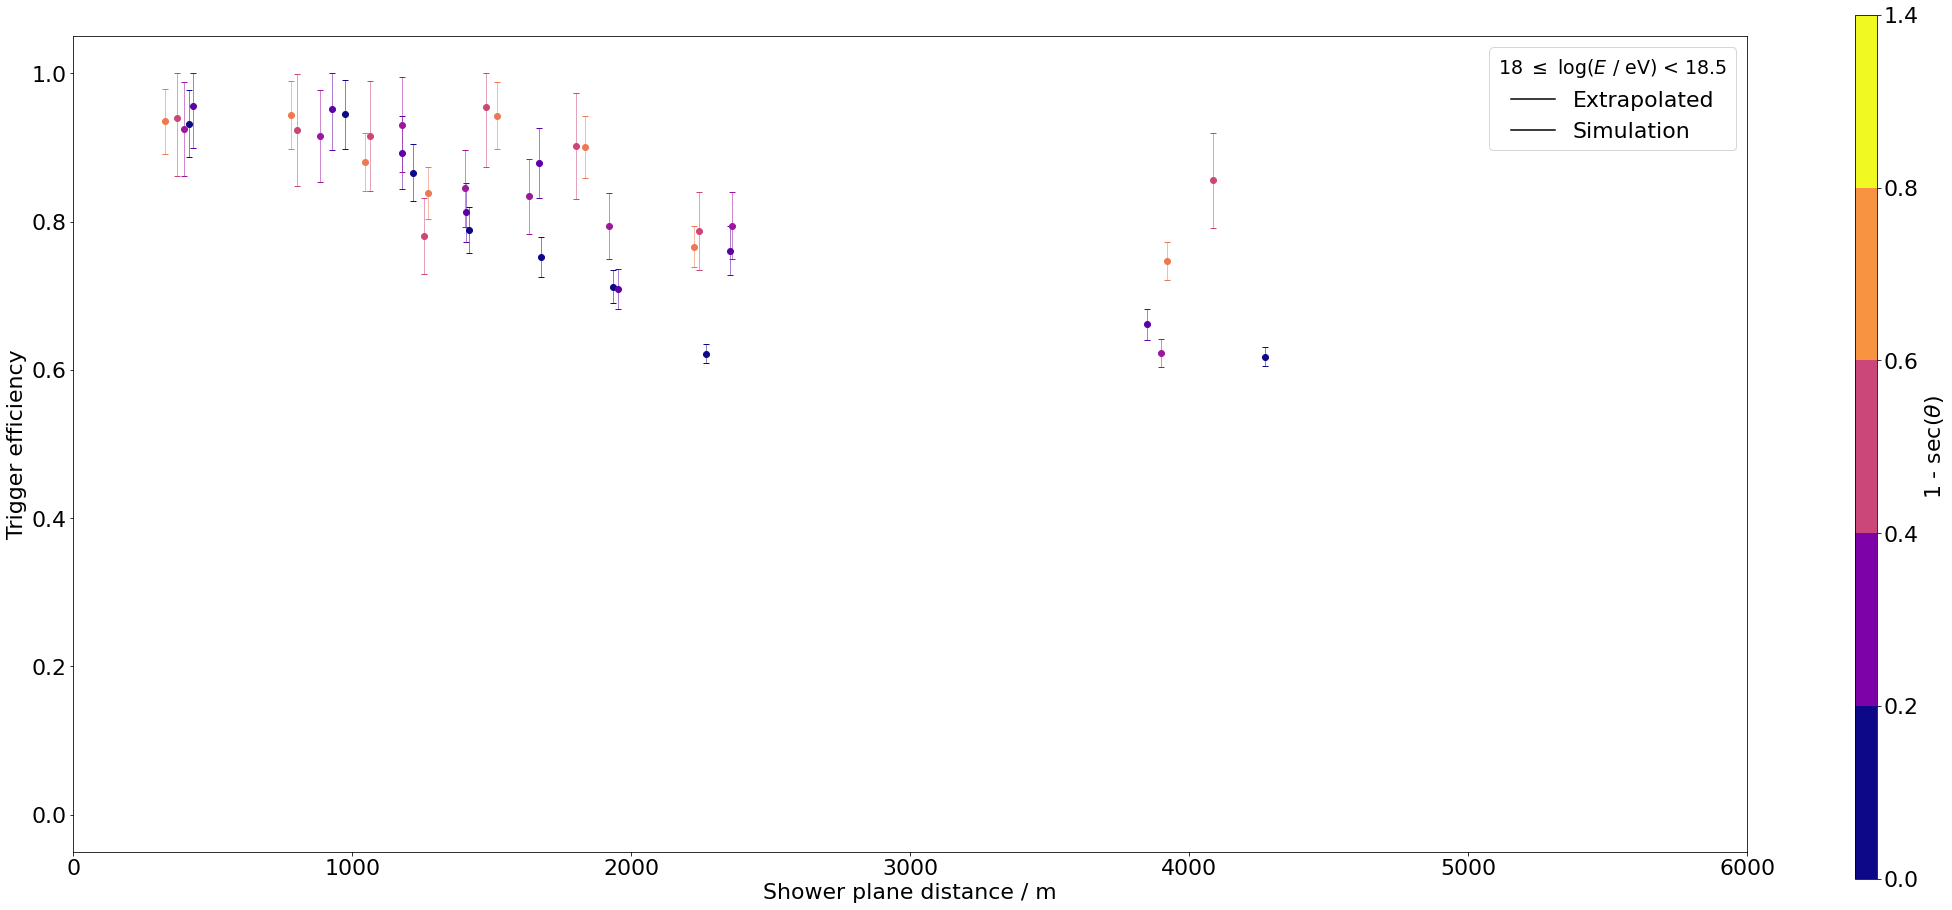

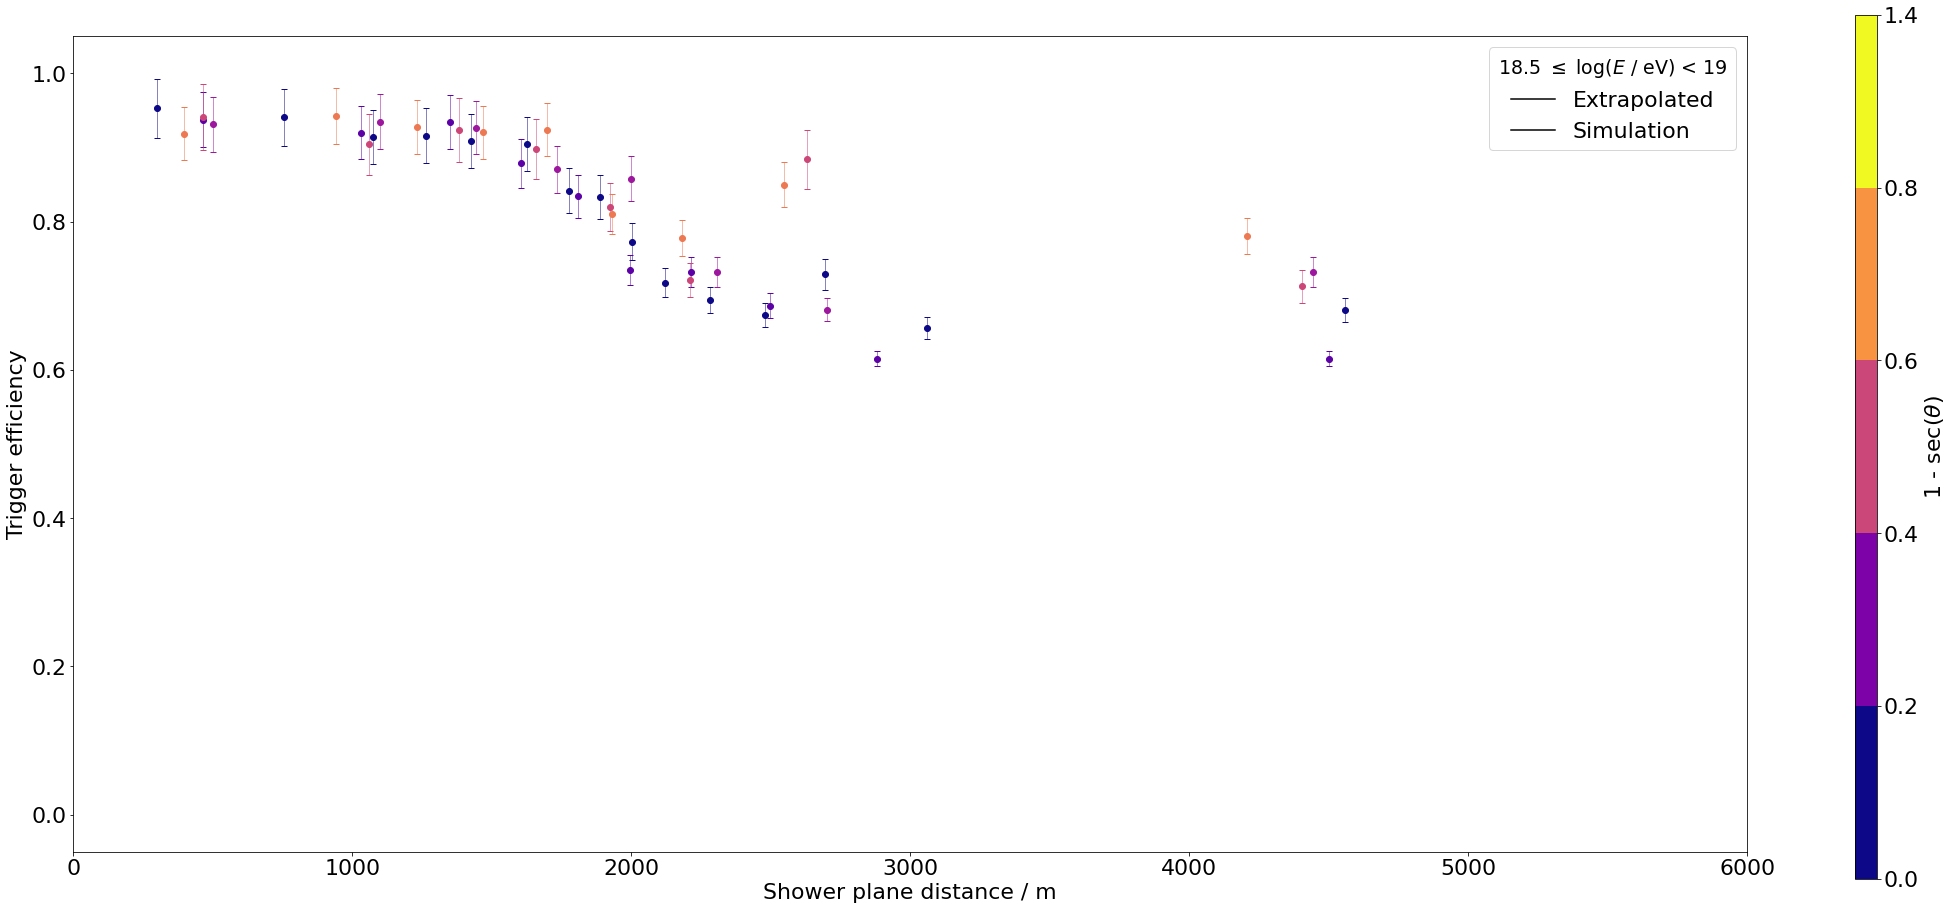

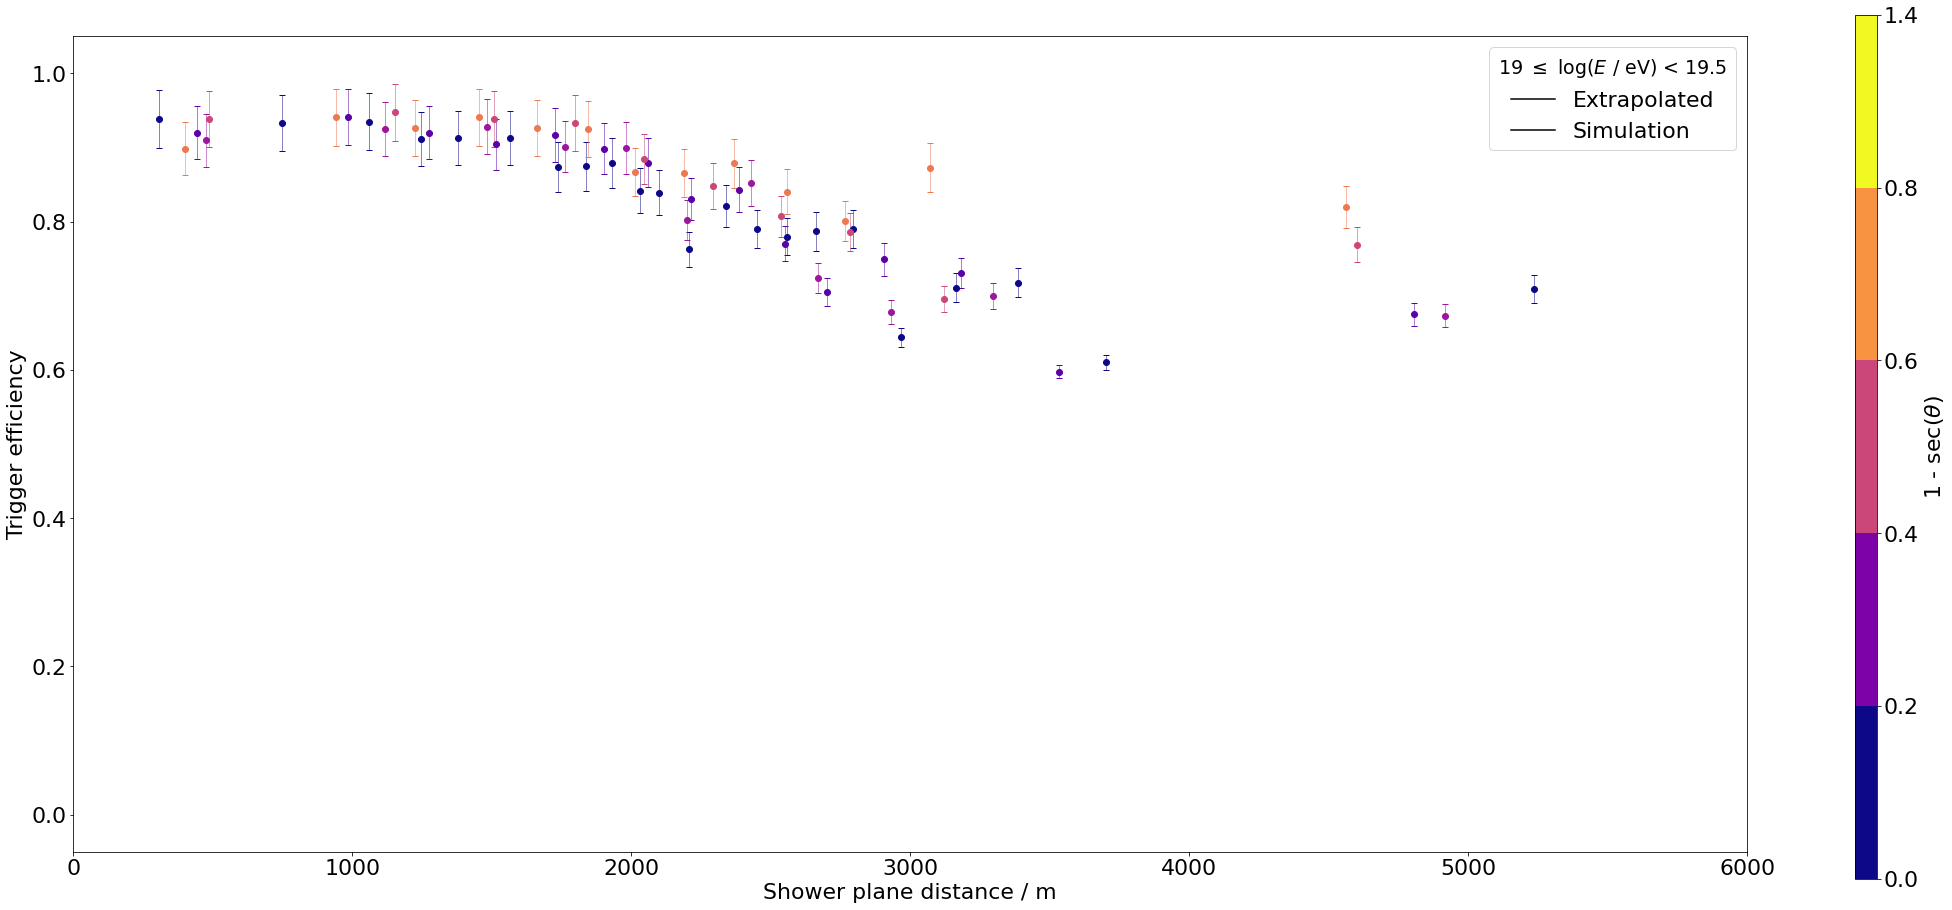

In [5]:
Assifier = NNClassifier("120_TwoLayer_FullBandwidth_NoCuts")
Assifier.spd_energy_efficiency("validation_data", perform_fit = False)

In [6]:
Hardware.do_t3_simulation("fullscale_random_traces_downsampled_scaled")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/cr/users/filip/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2061283/3251578633.py", line 1, in <cell line: 1>
    Hardware.do_t3_simulation("fullscale_random_traces_downsampled_scaled")
  File "/cr/users/filip/Binaries/Classifier.py", line 603, in do_t3_simulation
  File "/cr/users/filip/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py", line 1067, in loadtxt
    fh = np.lib._datasource.open(fname, 'rt', encoding=encoding)
  File "/cr/users/filip/anaconda3/lib/python3.9/site-packages/numpy/lib/_datasource.py", line 193, in open
    return ds.open(path, mode, encoding=encoding, newline=newline)
  File "/cr/users/filip/anaconda3/lib/python3.9/site-packages/numpy/lib/_datasource.py", line 533, in open
    raise IOError("%s not found." % path)
OSError: /cr/data01/filip/models/HardwareClassifier/ROC_curve/fullscal